<a href="https://colab.research.google.com/github/LucianoTrujillo/7506R-2C2022-GRUPO10/blob/main/7506R_TP1_GRUPO10_ENTREGA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#**TP1: Propiedades en Venta**



---


---


## *Facultad de Ingeniería, Universidad de Buenos Aires*

---
### *2do Cuatrimestre de 2022*

---
### *Organización de Datos*

### *Curso: Rodriguez*

### *Integrantes:*

* Luciano Leon Trujillo Palomo ltrujillo@fi.uba.ar 105664
* María Pilar Gaddi mgaddi@fi.uba.ar 105682
* Federico Adrian Solari Vazquez fsolariv@fi.uba.ar 106895
* Maria Vazquez Navarro mvazquezn@fi.uba.ar 105576
* Mateo Bulnes mbulnes@fi.uba.ar 106211
---

## **Objetivo del trabajo**

---
---

El objetivo de la siguiente investigación es aplicar técnicas de análisis exploratorio, preprocesamiento
de datos, agrupamiento, clasificación y regresión sobre un dataset real y poder obtener conclusiones y predicciones útiles. En especial, identificamos tres objetivos individuales:
* analizar si es posible agrupar los datos en función de
algún criterio, identificando a qué obedece el mismo.
* clasificar cada anuncio en tres categorías relacionadas al
precio de venta (alto, medio y bajo).
* predecir el precio de venta en dólares de una propiedad tipo
vivienda ubicada en Capital Federal.

---





## **Setup previo**


Importamos todas las librerías a utilizar a lo largo del trabajo:

In [358]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

# para pca
from sklearn import datasets
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.preprocessing import StandardScaler



Importamos el dataset original y lo guardamos para su posterior uso:

In [359]:

dwn_url='https://drive.google.com/uc?id=1z05Y6UwTu8fz1DpeE4JlRoyjJx_vPKmM'
ds_original = pd.read_csv(dwn_url)
ds_original.head(5)

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
0,XZq2dFGxBiboHY3Bo/tqlw==,2021-09-09,2022-01-27,2021-09-09,-38.957632,-68.105443,Neuquén,NaN,NaN,NaN,NaN,Venta,Casa,6.0,NaN,NaN,206.0,NaN,NaN,Casa - Capital
1,8afoK+yMH/rnnlYiktwgNA==,2021-09-09,2021-10-23,2021-09-09,-34.888878,-56.092368,Montevideo,NaN,NaN,NaN,NaN,Venta,Casa,4.0,3.0,193.0,193.0,390000.0,USD,Casa - Malvín
2,iVaG5rBB47dd1Ya4BMXREA==,2021-09-09,2022-03-09,2021-09-09,-32.488717,-58.257499,Entre Ríos,NaN,NaN,NaN,NaN,Venta,Casa,NaN,NaN,110.0,45.0,47000.0,USD,Casa - Uruguay
3,QE1QVMWKAHWkd0qT0FtPWA==,2021-09-09,2022-01-27,2021-09-09,-34.900165,-54.808453,Maldonado,NaN,NaN,NaN,NaN,Venta,Casa,NaN,3.0,NaN,180.0,400000.0,USD,Casa - El Chorro
4,tJ5lSk7IysG/71OGhacNZA==,2021-09-09,2022-01-27,2021-09-09,-38.954528,-68.041862,Neuquén,NaN,NaN,NaN,NaN,Venta,PH,3.0,2.0,NaN,98.0,102000.0,USD,PH - Villa Farrell


In [360]:
def mostrar_metadata_grafico(titulo, ylabel=None, xlabel=None, leyendas=None):
  plt.title(titulo)
  if ylabel:
    plt.ylabel = ylabel
  if xlabel:
    plt.xlabel = xlabel
  if leyendas:
    plt.legend = leyendas
  plt.show()



---
---


# Análisis Exploratorio y Preprocesamiento de Datos
---
---



## Pre-selección de datos
---
El primer paso consiste en la selección de los datos que se van a utilizar, se deben filtrar
únicamente los anuncios de propiedades de tipo vivienda ( Casa, PH y Departamento ) ubicados
en Capital Federal cuyo tipo de operación sea venta y su precio se encuentre en dólares (USD).

Primero filtramos por tipo de vivienda:

In [361]:
ds = ds_original.copy()
ds = ds.query('property_type == "Casa" or property_type == "Departamento" or property_type == "PH"')

Luego filtramos los ubicados en Capital Federal: 



In [362]:
ds.query('\
place_l3=="Capital Federal" or \
place_l4=="Capital Federal" or \
place_l5=="Capital Federal" or \
place_l6=="Capital Federal"').size

0

Observamos que la única columna que contiene a la clasificación de Capital Federal es place_l2, con lo cual con filtrar por l2, nos aseguramos de únicamente quedarnos con las filas que cumplan ser de Capital Federal.

In [363]:
ds = ds.query('place_l2 == "Capital Federal"')

Filtramos por tipo de operación (Venta):

In [364]:
ds = ds.query('operation == "Venta"')

Filtramos por moneda (USD):

In [365]:
ds = ds.query('property_currency == "USD"')

Comparamos el tamaño del ds original y el que utilizaremos para el análisis en el trabajo:

In [366]:
print("Tamaño original:", ds_original.shape, "Tamaño actual", ds.shape)

Tamaño original: (460154, 20) Tamaño actual (94249, 20)


#### Filtrado de valores inválidos

#####Duplicados

Analizaremos la cantidad de duplicados del dataset.

In [367]:
ds[ds.duplicated(subset=['id'])].shape[0]

0

Observamos que no hay datos duplicados segun el id. 

In [368]:
columnas = ds.columns.to_list()#
columnas.remove('id')
ds_aux=ds[ds.duplicated(subset=columnas)]
ds_aux.shape[0]*100/ds.shape[0]

1.2965654808008573


Con lo observado asumimos que el id se genera automaticamente al ingresar datos, sin antes verificar que los mismos no hayan sido ingresados antes.
Siendo que la proporcion de los datos duplicados resulta ser muy chica, nos parece correcto eliminarlos. 

Sin embargo notamos el hecho de que podrian presentarse casos de departamentos en los cuales todo sea igual, y se trate de dos departamentos en distintos pisos de un edificio, por lo tanto a continuacion analizaremos la frecuencia de esos casos.

In [369]:
dup_casa_bool=ds_aux.property_type != "Departamento"
dup_casa_bool.sum()

ds_solo_deptos_duplicados=ds_aux.drop(ds_aux[dup_casa_bool].index) #dejamos esta variable, porque nos interesan las cantidad para anlaizar LO QUE FALTA
print(ds_aux.property_title.unique().size)
print(ds_solo_deptos_duplicados.property_title.unique().size)

688
600


Vemos que los datos de departamentos que se encuentran duplicados son 688, mientras que si eliminamos los duplicados, nos quedariamos con un total de 600 casos unicos. 

Nos parece razonable eliminar esos 88, siendo que en el peor de los casos solo estariamos perdiendo 88 departamentos que en realidad se encuentren en el mismo edificio, lo cual no nos parece que aporte tanto a nuestro modelo. 

Con los casos de PH y Casa no nos parece necesario hacer el analisis anteior, siendo que en estos casos la latitud y longitud si deberian cambiar en caso de tratarse de casas o PHs diferentes. Por lo tanto eliminamos los casos duplicados.

In [370]:
print(ds.shape[0])
ds_a=ds.drop(ds[ds.duplicated(subset=columnas, keep='first')].index)
print(ds_a.shape[0])

94249
93027


##### tener mas superficie cubierta que superficie total

Notamos que los registros que tengan mas superficie cubierta que total seran invalidos, siendo que no se puede cubrir mas superficie que con la que se cuenta. Analizamos esos registros:

In [371]:
print(ds[ds['property_surface_total'] < ds['property_surface_covered']].shape[0])
print(ds[ds['property_surface_total'] < ds['property_surface_covered']].shape[0]*100/ds.shape[0])

198
0.21008180458148096


Observando bajas cantidades de estos registros decidimos eliminarlos del dataset.

In [372]:
ds.drop(ds[ds['property_surface_total'] < ds['property_surface_covered']].index, inplace=True)

##### tener cubierta de 1.0 

In [373]:
print(ds[ds['property_surface_covered'] == 1.0].property_surface_total)
print('porcentaje: ', ds[ds['property_surface_covered'] == 1.0].property_surface_total.shape[0]*100/ds.shape[0])



6980        NaN
7869        NaN
7881        NaN
10472       NaN
17494       NaN
41408       NaN
41540       NaN
41742       NaN
41746       NaN
41866       NaN
41903       NaN
41935       NaN
41944       NaN
41975       NaN
41980       NaN
41987       NaN
41995       NaN
42004       NaN
42078       NaN
42084       NaN
55729     117.0
193691     80.0
227332      NaN
326305      NaN
405728      NaN
405778    117.0
412097     50.0
438089      NaN
458875      NaN
Name: property_surface_total, dtype: float64
porcentaje:  0.03083433456316254


In [374]:
ds.drop(ds[ds['property_surface_covered'] == 1.0].index , inplace=True)


Notamos que una cubierta de 1.0 no tiene sentido. Al analizar la total vemos que la mayoria so datos invalidos. Siendo que las cantidades de registros con estas caracteristicas es razonablemente pequeña a comparacion de la totalidad de los datos, decidimos eliminar los registros. 

##### tener mas habitaciones que ambientes

Realizamos un análisis sobre los posibles registros que podrían llegar a generar valores atípicos en  property_bedrooms. 

Debido a la alta correlación que tienen property_bedrooms y property_rooms, consideramos que property_rooms es el mejor candidato para determinar los valores atípicos de property_bedrooms. 

In [375]:
pd.crosstab(ds.property_rooms, ds.property_bedrooms) 

property_bedrooms,-1.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,14.0,15.0,16.0,17.0,18.0,20.0,22.0,30.0,32.0,70.0
property_rooms,,,,,,,,,,,,,,,,,,,,,
1.0,0,5480,28,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2.0,1,25830,227,9,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3.0,0,449,25551,345,46,2,1,0,0,0,...,0,0,0,0,0,4,0,0,0,1
4.0,0,34,1268,14555,307,15,9,1,1,0,...,0,0,0,0,0,0,0,1,1,0
5.0,0,1,122,1948,2929,48,8,3,2,0,...,0,0,0,0,0,0,1,0,0,0
6.0,0,0,35,458,822,473,19,1,3,0,...,0,0,0,0,0,0,0,0,0,0
7.0,0,1,3,101,349,173,82,10,1,0,...,0,0,0,0,0,0,0,0,0,0
8.0,0,0,4,16,133,84,56,47,10,0,...,0,1,0,0,0,0,0,0,0,0
9.0,0,0,0,17,37,37,21,18,16,0,...,0,0,0,0,0,0,0,0,0,0


Viendo la tabla, pudimos visulizar que en caso de que la cantidad de ambientes sea menor a la cantidad de habitaciones, property_bedrooms seria un valor atipico.

Se puede visualizar que una gran cantidad de registros de property_bedrooms son valores atípicos ya que los valores de los mismos son mayores a los valores de los registros de property_rooms. 

Además, notamos que hay valores de property_bedrooms negativos, con lo cual esos valores también serían atípicos.

In [376]:
cond_mas_bedrooms_que_rooms = ds['property_bedrooms'] > ds['property_rooms']

reg_mas_bed_que_rooms = ds[cond_mas_bedrooms_que_rooms]
reg_mas_bed_que_rooms.shape

(150, 20)

Como podemos observar hay 16604 registros de los cuales hay mas habitaciones en la propiedad que cantidad de ambientes, por lo tanto serian valores atipicos por lo que consideramos que hay que eliminarlos

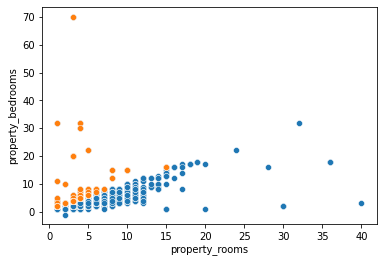

In [377]:
# sns.set(rc={"figure.figsize":(8, 8)}) #aumenta el tamaño del grafico
sns.scatterplot(data = ds, x = "property_rooms", y = "property_bedrooms")
sns.scatterplot(data = reg_mas_bed_que_rooms, x = "property_rooms", y = "property_bedrooms")#grafico de valores atipicos

In [378]:
ds.drop(reg_mas_bed_que_rooms.index, inplace=True)# elimino las filas con mas bedrooms que rooms

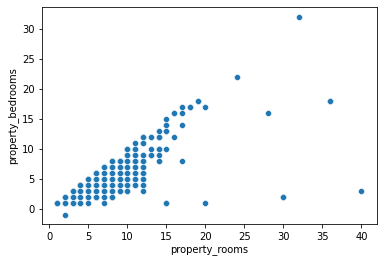

In [379]:
sns.scatterplot(data = ds, x = "property_rooms", y = "property_bedrooms")

In [380]:
cond_bedrooms_menores_a_uno = ds['property_bedrooms'] < 1
reg_con_bedrooms_menores_a_uno = ds[cond_bedrooms_menores_a_uno]
reg_con_bedrooms_menores_a_uno.shape

(1, 20)

Observamos que solo un registro contiene una cantidad de bedrooms menor o igual a cero, por ese motivo consideramos que debe ser eliminado

In [381]:
ds.drop(reg_con_bedrooms_menores_a_uno.index, inplace=True)# elimino las filas con mas bedrooms menores a 1

In [382]:
ds.columns.to_list()

['id',
 'start_date',
 'end_date',
 'created_on',
 'latitud',
 'longitud',
 'place_l2',
 'place_l3',
 'place_l4',
 'place_l5',
 'place_l6',
 'operation',
 'property_type',
 'property_rooms',
 'property_bedrooms',
 'property_surface_total',
 'property_surface_covered',
 'property_price',
 'property_currency',
 'property_title']

A continuacion demostramos que no se encuentran valores negativos en las columnas en donde los valores siempre deben ser positivos, por lo tanto no es necesario eliminar datos.

In [383]:
ds[ds['property_price'] < 1].shape 

(0, 20)

In [384]:
ds[ds['property_rooms'] < 1].shape

(0, 20)

In [385]:
ds[ds['property_surface_total'] < 1].shape

(0, 20)

In [386]:
ds[ds['property_surface_covered'] < 1].shape

(0, 20)

##### created_on < start_date < end_date




In [387]:
ds[ds['start_date'] < ds['created_on']].shape 

(0, 20)

In [388]:
ds[ds['end_date'] < ds['start_date']].shape 

(0, 20)

In [389]:
ds[ds['end_date'] < ds['created_on']].shape 

(0, 20)

Como podemos observar todas las fechas de los avisos que se encuentran en el dataset cumplen con las condiciones necesarias para ser consideradas validas.


## Exploración Inicial
---


### Clasificación  de variables 


####Variables cuantitativas discretas

- start date, end date, created on: 

    Las fechas pueden ser consideradas cuantitativas discretas dado que toman valores numéricos ordenables, y entre dos valores consecutivos no existen valores intermedios. 

- property_rooms, property_bedrooms: 

    Pueden ser consideradas cuantitativas discretas ya que pueden tomar un conjunto a lo sumo numerable de valores, y cuentan cosas.

#### Variables cuantitativas continuas

- latitud y longitud:  

    Estas variables al tomar valores numéricos en los cuales existen infinitos valores intermedios (son arbitrariamente fraccionables), pueden ser consideradas como continuas. 

- property_surface_total, property_surface_covered, property_price: 

    Al igual que las variables anteriores, estas pueden tomar infinitos valores numéricos intermedios y por esa razón son consideradas continuas. 

####Variables cualitativas nominales

- id: 

    Es una variable cualitativa numérica que representa una identificación, cada una de estas es diferente y no tienen un orden visible. 

- place_l2, place_l3, place_l4, place_l5, place_l6: 

    Son variables de texto no trivialmente ordenables, dado que simplemente son un nombre correspondiente a la ubicación geográfica.

- operation, property_type, property_currency: 

    Son variables de texto que representan características para diferenciar propiedades entre sí, pero al igual que places, no tienen un ordenamiento predefinido. 

#### Variables irrelevantes


Observando las variables nombradas, consideramos las siguiente variables irrelevantes para el analisis:



- id: 

    El la campo Id es irrelevante ya que no aporta información sobre las viviendas, simplemente es utilizado para guardar la información en la base de datos.



- place_l5, place_l6:  
    
    Ambos campos son irrelevantes dado que no poseen datos que brinden información de gran importancia para el dominio del problema (todos los datos son nulos).



- property_title: 
    
    Dado que no haremos un análisis de NLP, no nos es relevante este campo.

###Variables cuantitativas
---


#### Cálculo medidas de resumen

Como debemos calcular la media, mediana, q1, q3 y moda para las variables start_date, end_date, created_on y las mismas son fechas, debemos convertirlas a un tipo de dato adecuado:

In [390]:
ds_filtrado = ds.copy()
ds_filtrado['start_date']=pd.to_datetime(ds_filtrado['start_date'], errors='ignore')
ds_filtrado['created_on']=pd.to_datetime(ds_filtrado['created_on'], errors='ignore')

In [391]:
try: 
    pd.to_datetime(ds_filtrado['end_date'])
except Exception as e: print(e)

Out of bounds nanosecond timestamp: 9999-12-31 00:00:00


Observamos que la columna end_date tiene una row cuyo valor es inválido: "9999-12-31", con lo cual averiguamos cuantos de éstos valores inválidos hay:

In [392]:
invalid_end_dates = ds_filtrado.end_date[lambda date: pd.isnull(pd.to_datetime(date, errors='coerce'))]
invalid_end_dates.size


5019

Encontramos 5041 apariciones de fecha invalidas. En la sección de Feature Engineering analizaremos que hacer con estos datos. <font color=red>Mientras tanto, hacemos un dataset que no contenga a las fechas inválidas para poder calcularle los valores pedidos.</font>

In [393]:
ds_end_date = ds_filtrado.copy()
cond_operacion = pd.notnull(pd.to_datetime(ds_end_date['end_date'], errors='coerce'))
ds_end_date = ds_end_date[cond_operacion]
ds_end_date.end_date = pd.to_datetime(ds_end_date['end_date'])

In [394]:
def mostrar_medidas_resumen(columna, ylabel=None, show_boxplot=True, df=ds_filtrado):
    mean=df[columna].mean()

    measure_info=np.nanpercentile(df[columna],[25,50,75])
    
    mode=df[columna].mode()

    print(f'Medidas de resumen para la variable {columna}:\n\
    \tMedia: {mean}\n\
    \tq1: {measure_info[0]}\n\
    \tMediana: {measure_info[1]}\n\
    \tq3: {measure_info[2]}\n\
    \tModa: {mode}')

    if(show_boxplot):
        sns.boxplot(y=df[columna], showfliers = False) # no mostramos outliers para ver mejor la distribución
        mostrar_metadata_grafico(f"distribución de {ylabel} en formato boxplot", ylabel=ylabel)

##### start date

In [395]:
mostrar_medidas_resumen('start_date', show_boxplot=False)

Medidas de resumen para la variable start_date:
    	Media: 2021-07-01 11:21:44.952541184
    	q1: 2021-04-04T00:00:00.000000000
    	Mediana: 2021-06-29T00:00:00.000000000
    	q3: 2021-09-24T00:00:00.000000000
    	Moda: 0   2021-12-16
dtype: datetime64[ns]


#####created_on

In [396]:
mostrar_medidas_resumen('created_on', show_boxplot=False)

Medidas de resumen para la variable created_on:
    	Media: 2021-07-01 11:21:44.952541184
    	q1: 2021-04-04T00:00:00.000000000
    	Mediana: 2021-06-29T00:00:00.000000000
    	q3: 2021-09-24T00:00:00.000000000
    	Moda: 0   2021-12-16
dtype: datetime64[ns]


#####end_date

In [397]:
mostrar_medidas_resumen('end_date', show_boxplot=False, df=ds_end_date)

Medidas de resumen para la variable end_date:
    	Media: 2021-09-14 13:25:21.649484544
    	q1: 2021-06-05T00:00:00.000000000
    	Mediana: 2021-08-30T00:00:00.000000000
    	q3: 2022-01-27T00:00:00.000000000
    	Moda: 0   2021-06-05
dtype: datetime64[ns]


#####property_rooms

Medidas de resumen para la variable property_rooms:
    	Media: 2.820356765840102
    	q1: 2.0
    	Mediana: 3.0
    	q3: 4.0
    	Moda: 0    3.0
dtype: float64


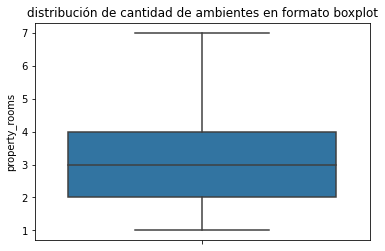

In [398]:
mostrar_medidas_resumen('property_rooms', ylabel="cantidad de ambientes")

##### property_bedrooms

Medidas de resumen para la variable property_bedrooms:
    	Media: 2.005233644859813
    	q1: 1.0
    	Mediana: 2.0
    	q3: 3.0
    	Moda: 0    1.0
dtype: float64


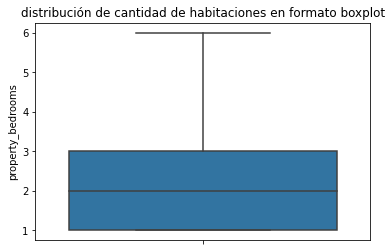

In [399]:
mostrar_medidas_resumen('property_bedrooms', ylabel="cantidad de habitaciones")

#####latitud

Medidas de resumen para la variable latitud:
    	Media: -34.59146461845102
    	q1: -34.615935
    	Mediana: -34.595766
    	q3: -34.5774
    	Moda: 0   -34.54125
dtype: float64


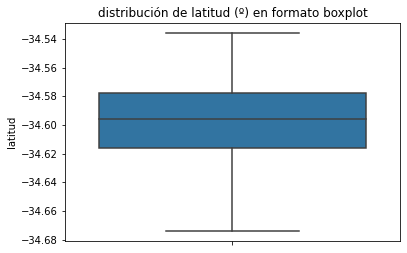

In [400]:
mostrar_medidas_resumen('latitud', ylabel="latitud (º)")

#####longitud

Medidas de resumen para la variable longitud:
    	Media: -58.44982044949159
    	q1: -58.46651
    	Mediana: -58.4390044212
    	q3: -58.40887
    	Moda: 0   -58.472966
dtype: float64


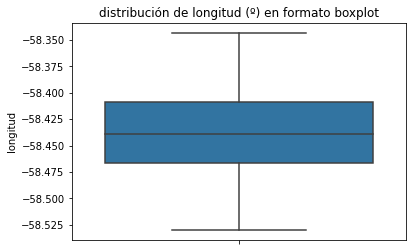

In [401]:
mostrar_medidas_resumen('longitud', ylabel="longitud (º)")

#####property_surface_total

Medidas de resumen para la variable property_surface_total:
    	Media: 108.90567944485616
    	q1: 45.0
    	Mediana: 65.0
    	q3: 104.0
    	Moda: 0    50.0
dtype: float64


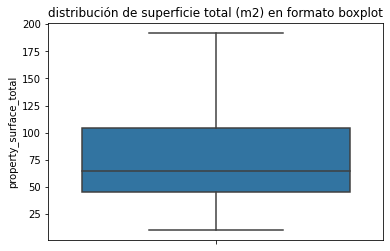

In [402]:
mostrar_medidas_resumen('property_surface_total', ylabel="superficie total (m2)")

#####property_surface_covered

Medidas de resumen para la variable property_surface_covered:
    	Media: 86.60087937339122
    	q1: 40.0
    	Mediana: 57.0
    	q3: 88.0
    	Moda: 0    40.0
dtype: float64


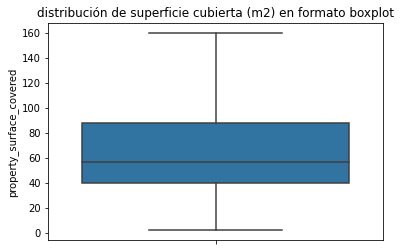

In [403]:
mostrar_medidas_resumen('property_surface_covered', ylabel="superficie cubierta (m2)")

#####property_price

Medidas de resumen para la variable property_price:
    	Media: 225056.9310969309
    	q1: 95000.0
    	Mediana: 143000.0
    	q3: 235000.0
    	Moda: 0    110000.0
dtype: float64


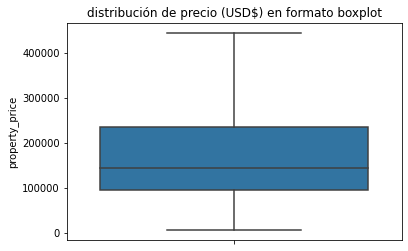

In [404]:
mostrar_medidas_resumen('property_price', ylabel="precio (USD$)")

#### Análisis gráfico de distribuciones

In [405]:
def mostrar_distribuciones_cuantitativas(variable, ds=ds_filtrado, figsize=(5,5), bins=None, binwidth=None, discrete=False, espaciado=4, rotacion=90):
  if binwidth:
    graph = sns.displot(ds, x=variable, discrete=discrete, bins=bins, binwidth=binwidth)
  else:
    graph = sns.displot(ds, x=variable, discrete=discrete, bins=bins)

  graph.fig.set_figheight(figsize[1])
  graph.fig.set_figwidth(figsize[0])
  ax = graph.ax
  mids = [rect.get_x() for rect in ax.patches]
  mids = [item for index, item in enumerate(mids) if index % espaciado == 0]
  ax.set_xticks(mids)
  ax.tick_params(axis='x', rotation=rotacion, labelsize=12)

  mostrar_metadata_grafico(f"distribución de {variable}", ylabel="frecuencia")



##### start_date

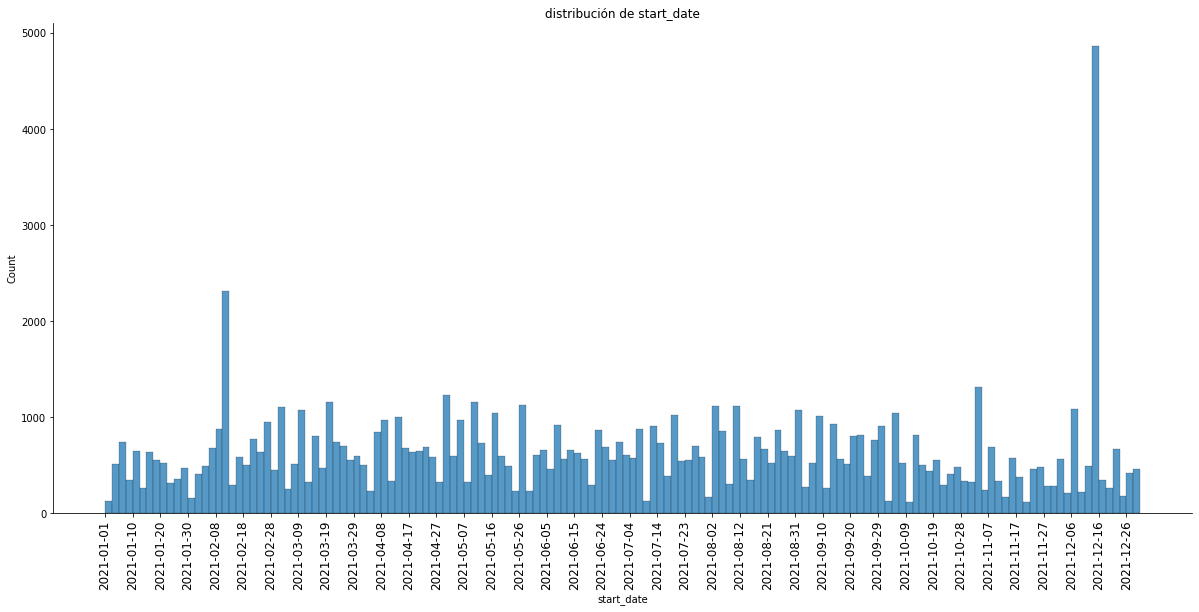

In [406]:
mostrar_distribuciones_cuantitativas("start_date", figsize=(20, 8), bins=150)

##### end_date

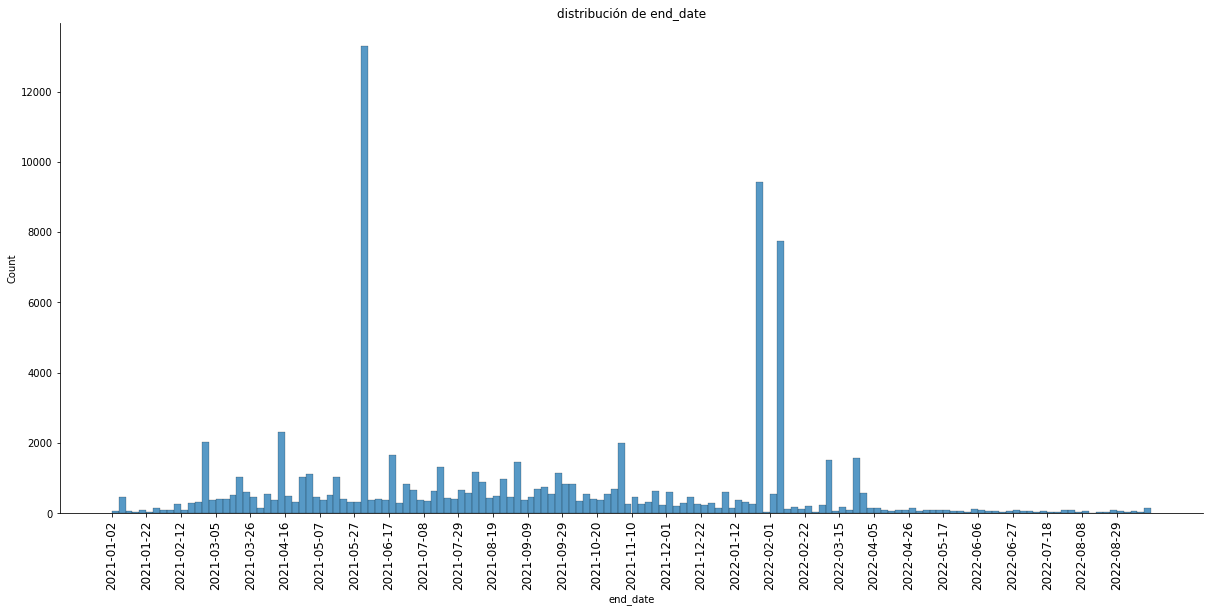

In [407]:
mostrar_distribuciones_cuantitativas("end_date", ds=ds_end_date, figsize=(20, 8), bins=150, espaciado=5)

#####created_on

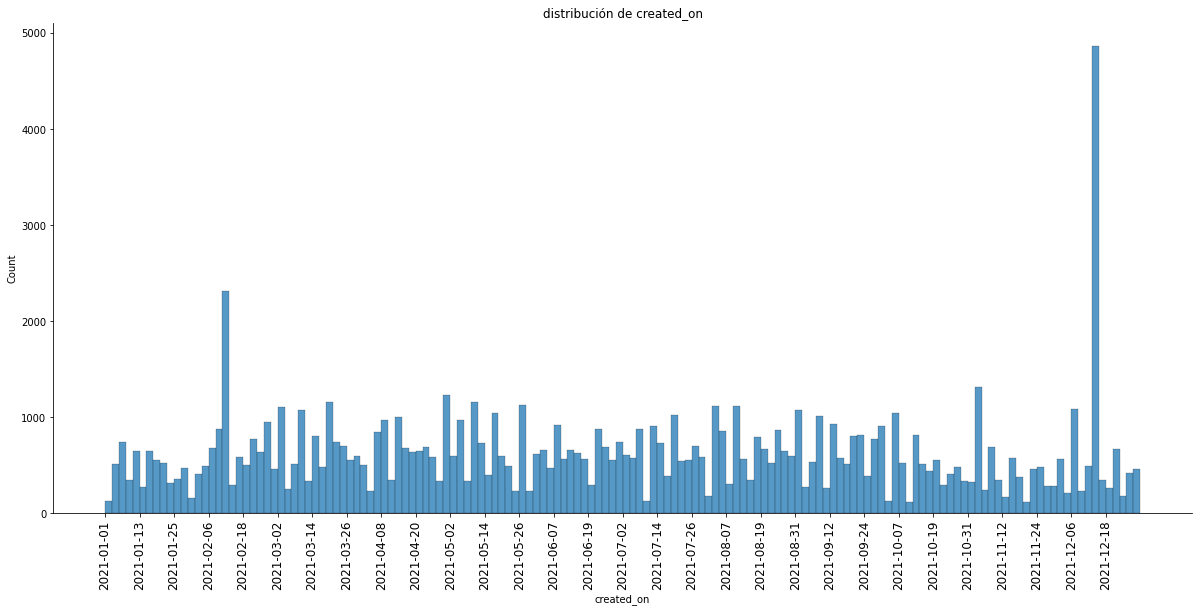

In [408]:
mostrar_distribuciones_cuantitativas("created_on", figsize=(20, 8), bins=150, espaciado=5)

#####property_rooms

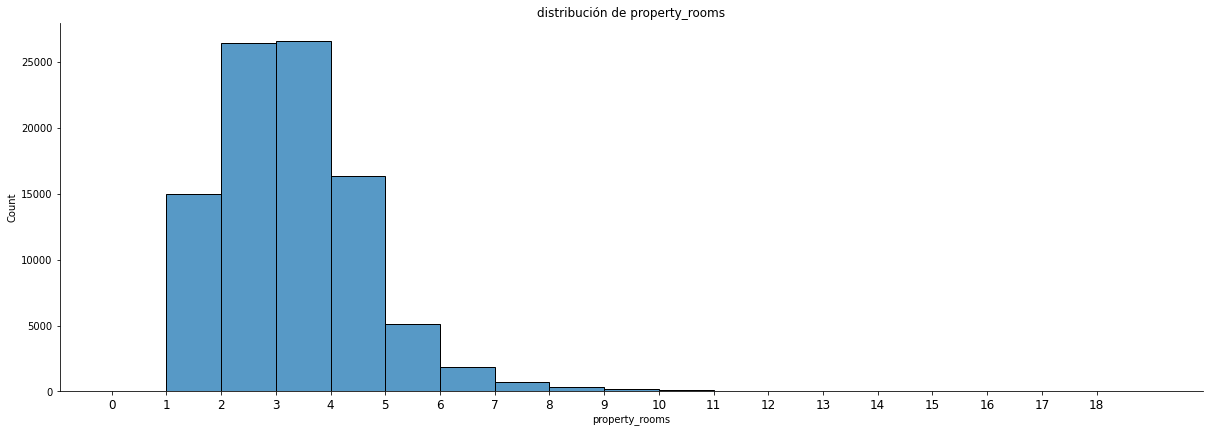

In [409]:
mostrar_distribuciones_cuantitativas("property_rooms", figsize=(20, 6), bins=[*range(20)], espaciado=1, rotacion=0)

#####property_bedrooms

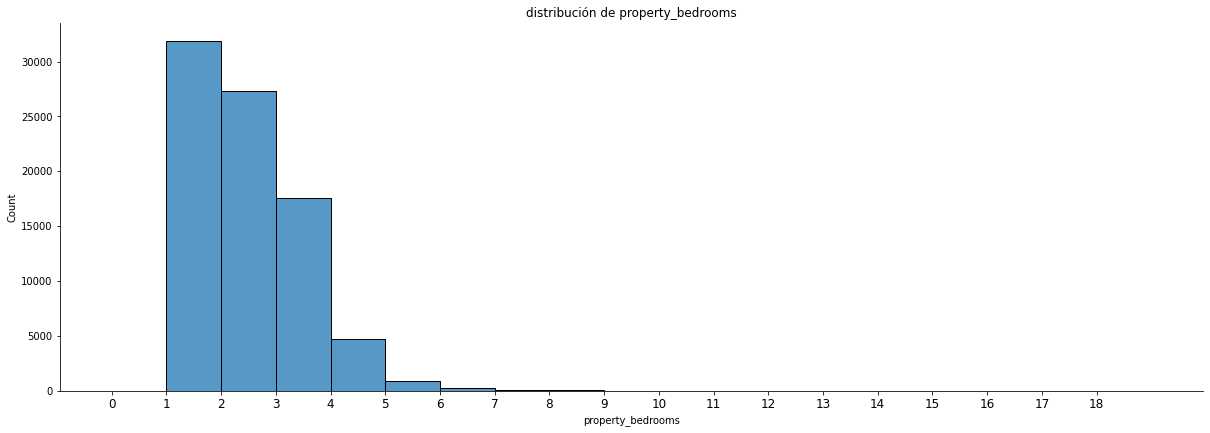

In [410]:
mostrar_distribuciones_cuantitativas("property_bedrooms", figsize=(20, 6), espaciado=1, bins=[*range(20)], rotacion=0)

#####property_surface_total

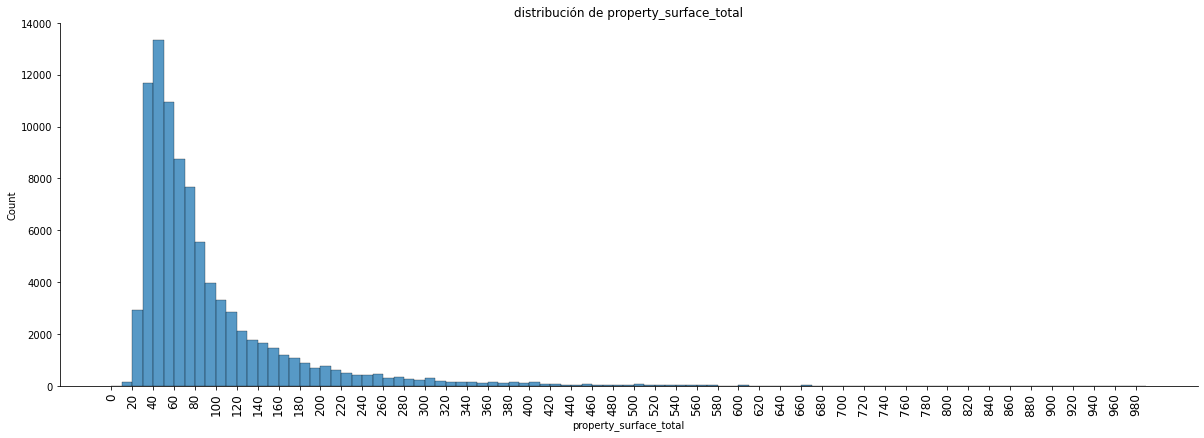

In [411]:
ds_property_surface_total_sin_outliers = ds_filtrado[['property_surface_total']]
ds_property_surface_total_sin_outliers = ds_property_surface_total_sin_outliers[(ds_property_surface_total_sin_outliers.property_surface_total > 0) & (ds_property_surface_total_sin_outliers.property_surface_total < 1000)]
mostrar_distribuciones_cuantitativas("property_surface_total", ds=ds_property_surface_total_sin_outliers, figsize=(20, 6), bins=[*range(0, 1000, 10)], espaciado=2)

##### property_surface_covered
<font color='red'>REVISAR, tendría mas sentido que sea continuo el grafico </font>

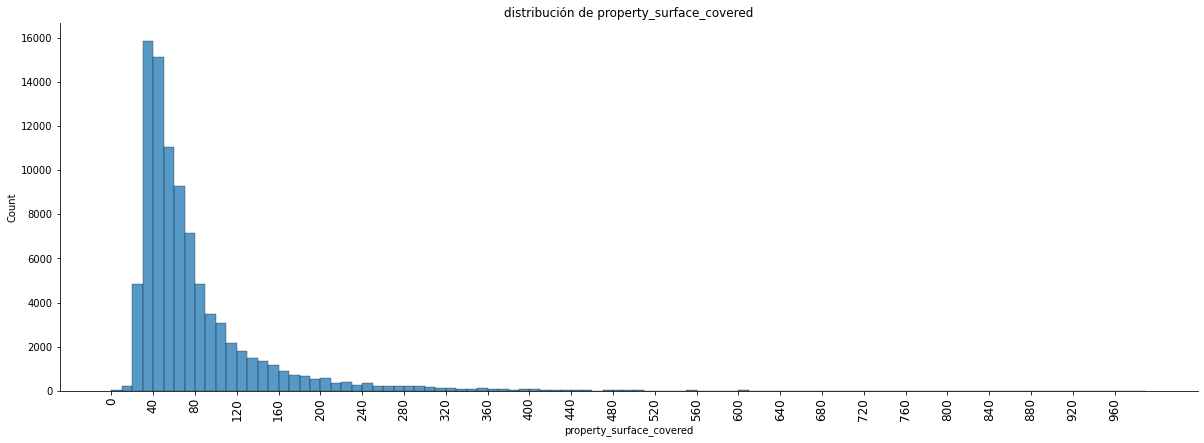

In [412]:
ds_property_surface_covered_sin_outliers = ds_filtrado[['property_surface_covered']]
ds_property_surface_covered_sin_outliers = ds_property_surface_covered_sin_outliers[(ds_property_surface_covered_sin_outliers.property_surface_covered > 0) & (ds_property_surface_covered_sin_outliers.property_surface_covered < 1000)]
mostrar_distribuciones_cuantitativas("property_surface_covered", ds=ds_property_surface_covered_sin_outliers, figsize=(20, 6), bins=[*range(0, 1000, 10)])

##### property_price
<font color='red'>REVISAR, tendría mas sentido que sea continuo el grafico </font>

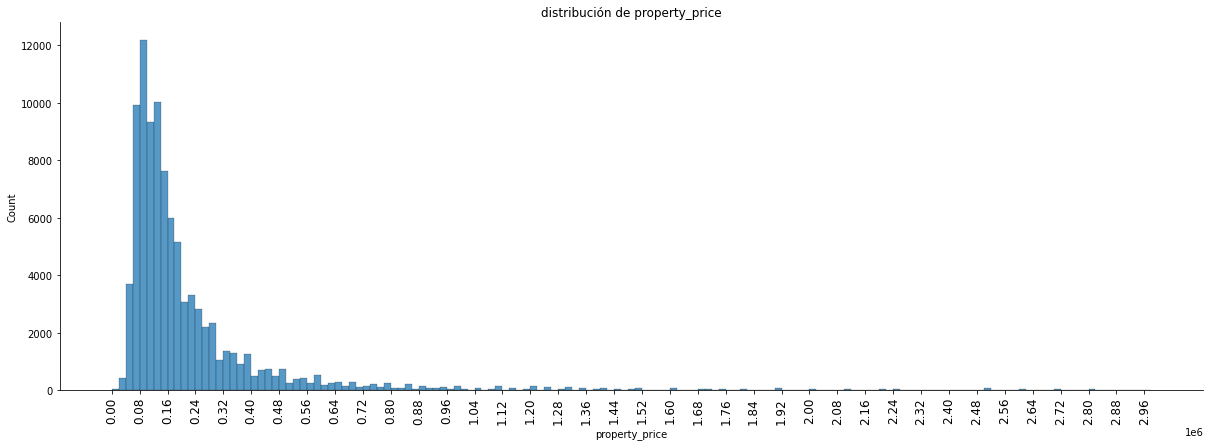

In [413]:
ds_property_price_sin_outliers = ds_filtrado[['property_price']]
ds_property_price_sin_outliers = ds_property_price_sin_outliers[(ds_property_price_sin_outliers.property_price > 0) & (ds_property_price_sin_outliers.property_price < 3000000)]
mostrar_distribuciones_cuantitativas("property_price", ds=ds_property_price_sin_outliers, figsize=(20, 6), bins=[*range(0, 3000000, 20000)], espaciado=4)


#####latitud

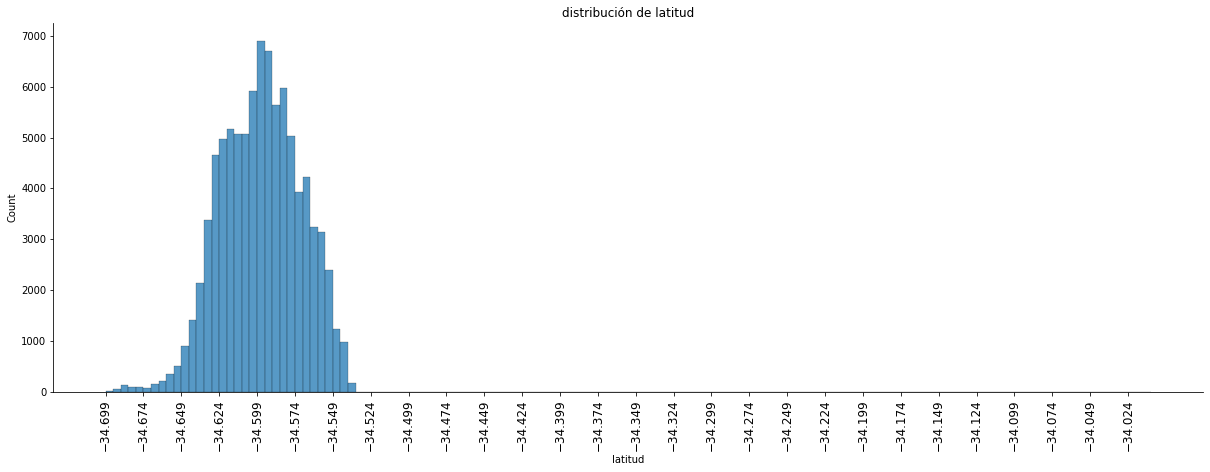

In [414]:
ds_latitud_sin_outliers = ds_filtrado[['latitud']]
ds_latitud_sin_outliers = ds_latitud_sin_outliers[(ds_latitud_sin_outliers.latitud > -38) & (ds_latitud_sin_outliers.latitud < -34)]
mostrar_distribuciones_cuantitativas("latitud", ds=ds_latitud_sin_outliers, figsize=(20, 6), binwidth=0.005, espaciado=5)

#####longitud

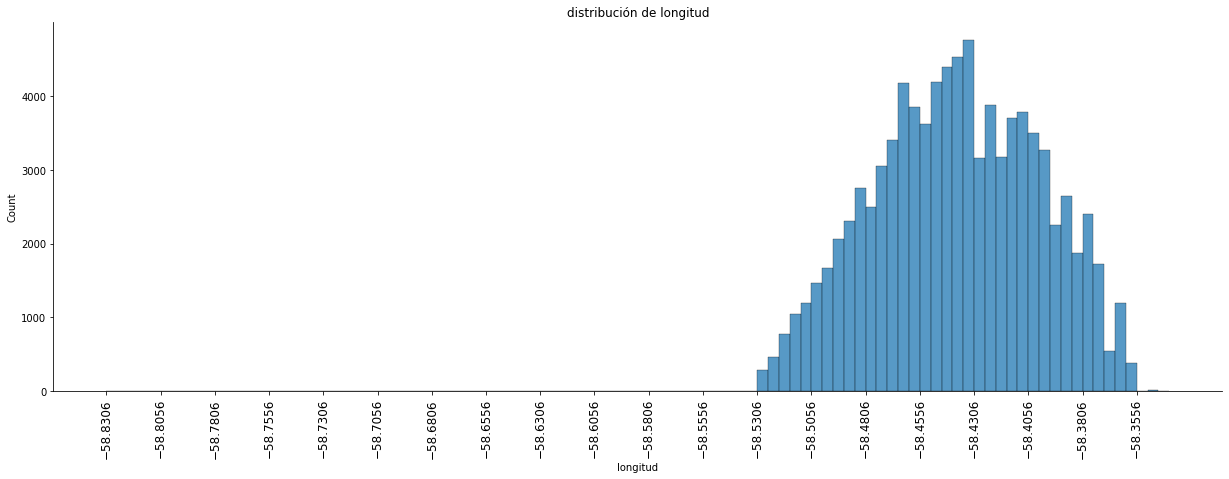

In [415]:
ds_longitud_sin_outliers = ds_filtrado[['longitud']]
ds_longitud_sin_outliers = ds_longitud_sin_outliers[(ds_longitud_sin_outliers.longitud > -59) & (ds_longitud_sin_outliers.longitud < -58)]
mostrar_distribuciones_cuantitativas("longitud", ds=ds_longitud_sin_outliers, espaciado=5, figsize=(20, 6), binwidth=0.005)

###### longitud y latitud en conjunto
<font color='red'>REVISAR, usar el random con una seed así siempre da el mismo resultado </font>

In [416]:
import json
import shapely
import requests
import random
from shapely.geometry import shape, Point
from shapely.ops import unary_union
from shapely.ops import unary_union



url='https://drive.google.com/file/d/1eeT_53CFY63d55oZo50F7mOKPTZMW--V/view?usp=sharing'
file_id=url.split('/')[-2]
dwn_url='https://drive.google.com/uc?id=' + file_id

url=requests.get(dwn_url)
data=url.text



data=json.loads(data)


caba_barrios = data
barrios = dict(
    (feature["properties"]["BARRIO"], shape(feature["geometry"])) 
    for feature in caba_barrios["features"]
)

all_barrios = unary_union(barrios.values())



def graficar_puntos_en_caba(longitudes, latitudes, tamano_de_punto=4,  proporcion=1):
  lat_long = list(zip(longitudes, latitudes))

  long_min, lat_min, long_max, lat_max = all_barrios.bounds

  viridis = cm.get_cmap('viridis', len(barrios) // 4)
  plasma = cm.get_cmap('plasma', len(barrios) // 4)
  inferno = cm.get_cmap('inferno', len(barrios) // 4)
  cividis = cm.get_cmap('cividis', len(barrios) - (len(barrios) // 4) * 3)
  colors = sum((list(x.colors) for x in (viridis, plasma, inferno, cividis)), [])

  random.shuffle(colors)


  f = plt.figure()
  f.set_figwidth(15)
  f.set_figheight(15)



  for idx, (barrio, shape) in enumerate(barrios.items()):
    for polygon in shape.geoms:
        plt.plot(*polygon.exterior.xy, color=colors[idx])
  
  values=lat_long.copy()
  random.shuffle(values)

  cont_outsiders=0
  cantidad = int(latitudes.size*proporcion)
  for dot in values[:cantidad]:     
    if(all_barrios.contains(Point(dot))):
       plt.scatter(x=dot[0], y=dot[1], s=tamano_de_punto, c='black')
    else: 
      cont_outsiders= cont_outsiders+1
 
  plt.show()
  print("El porcentaje de outsiders dentro de la proporcion pedida de la muestra es:", cont_outsiders/cantidad*100)

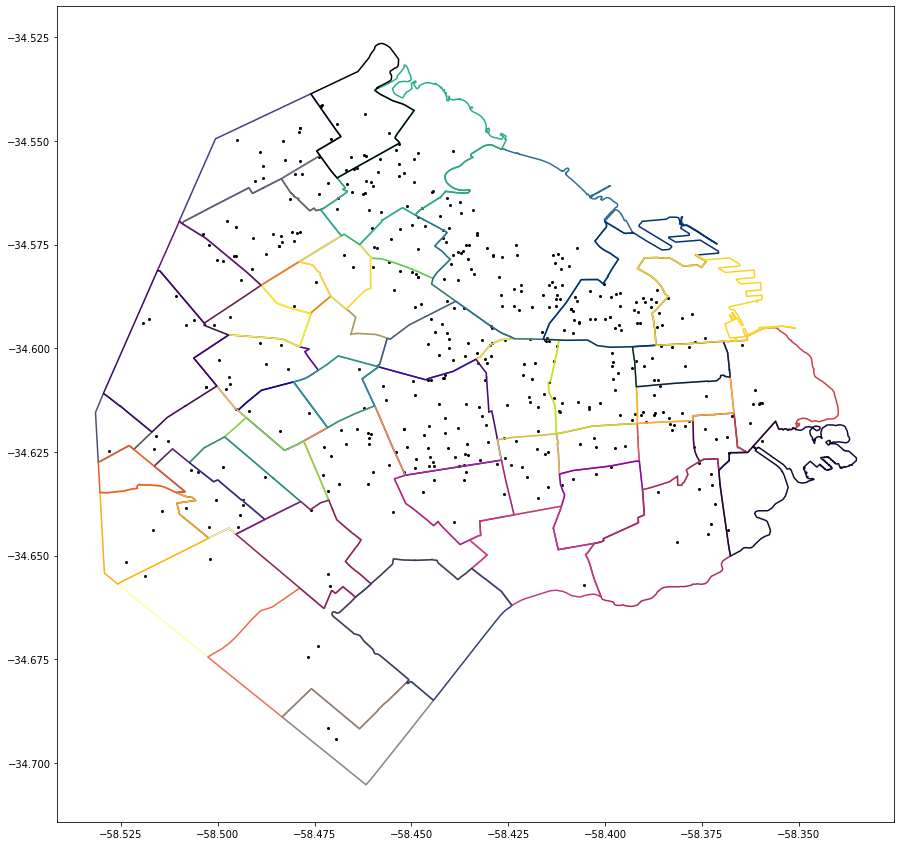

El porcentaje de outsiders dentro de la proporcion pedida de la muestra es: 4.690831556503198


In [417]:
graficar_puntos_en_caba(ds_filtrado.longitud, ds_filtrado.latitud, proporcion=0.005)

Como vemos, los puntos se distribuyen de manera coherente con la realidad, donde hay mas densidad de poblacion en sectores populares. Luego analizaremos los puntos faltantes y outsiders por separado, en la secciones correspondientes.   

### Variables Cualitativas
---


#### Cantidad de valores posibles y frecuencias

In [418]:
def mostrar_frecuencias(columna, ancho=4, alto=4):
    frecuencia_por_valor = ds_filtrado.groupby(columna).size().to_frame("frecuencia")
    frecuencia_por_valor = frecuencia_por_valor.sort_values(by="frecuencia", ascending=False).reset_index()
    frecuencia_por_valor.head(40).plot.bar(x=columna, y="frecuencia", figsize=(ancho, alto))
    mostrar_metadata_grafico(f"frecuencias de valores posibles de {columna}", ylabel="frecuencia", xlabel="valores posibles")
    

#####place_l2

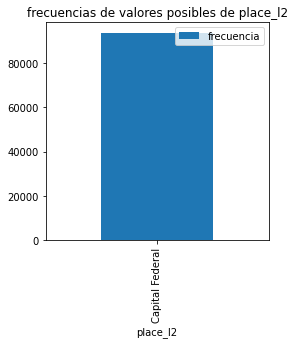

In [419]:
mostrar_frecuencias('place_l2')

#####place_l3

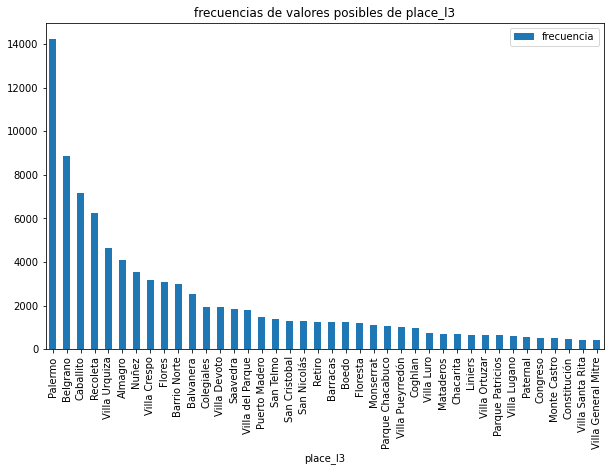

In [420]:
mostrar_frecuencias('place_l3', 10, 6)

#####place_l4

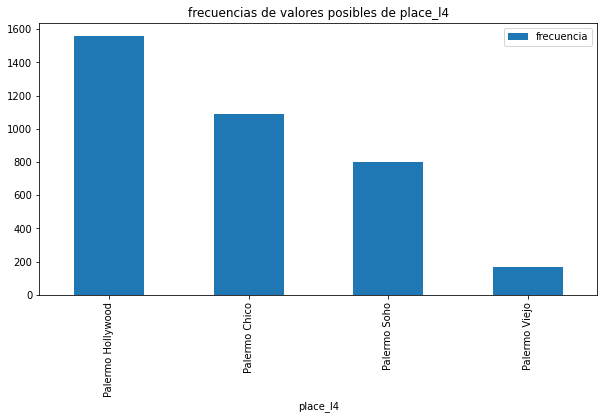

In [421]:
mostrar_frecuencias('place_l4', 10, 5)

#####operation

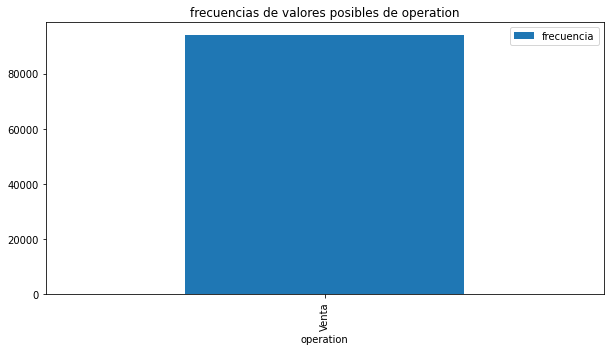

In [422]:
mostrar_frecuencias('operation', 10, 5)

#####property_type

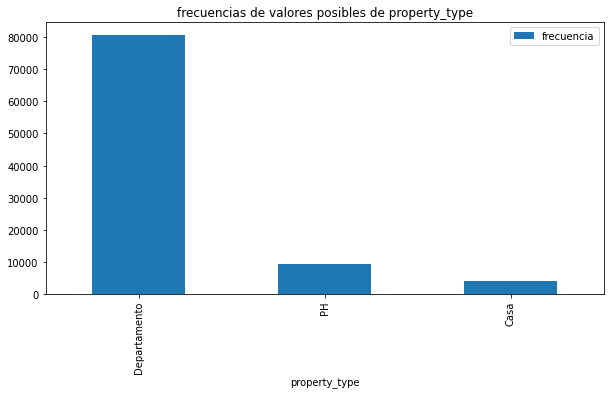

In [423]:
mostrar_frecuencias('property_type', 10, 5)

#####property_currency

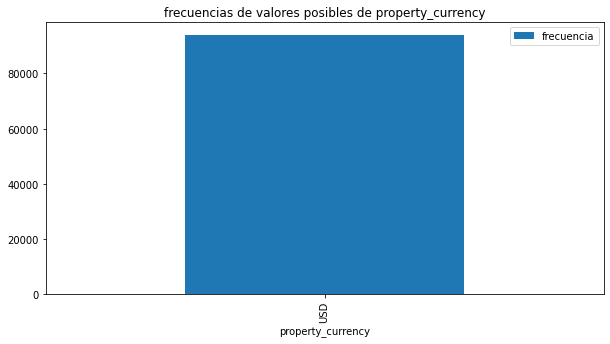

In [424]:
mostrar_frecuencias('property_currency', 10, 5)

## Análisis de Correlaciones existentes entre las variables
---



Eliminamos place_l6 al ser que tratan de elementos de tipo float64, siendo que no son validos como para evaluar correlaciones.

In [425]:
matriz_temp = ds_filtrado.drop(columns=['place_l6'])
matriz_correlacion = matriz_temp.corr()

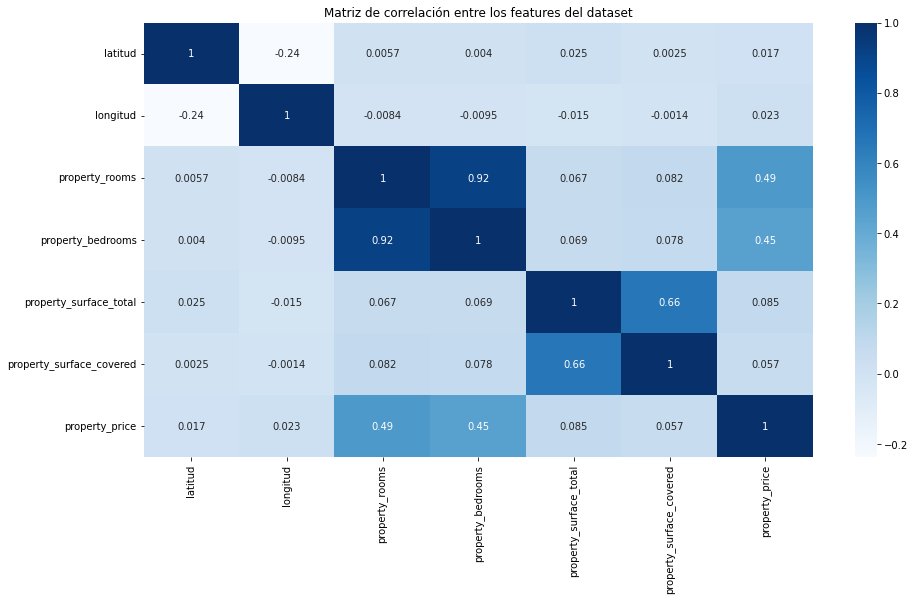

In [426]:
plt.figure(figsize = (15,8))
sns.heatmap(matriz_correlacion, annot = True, cmap='Blues')
mostrar_metadata_grafico("Matriz de correlación entre los features del dataset")

Como observamos del heatmap, hay ciertas variables con una correlación significativa, por ejemplo:

- la cantidad de habitaciones vs la cantidad de ambientes
- superficie cubierta vs superficie total
- precio vs cantidad de ambientes y habitaciones 

Estas relaciones tienen sentido, dado que uno esperaría que a medida aumenta la cantidad de ambientes (y/o cuartos), la propiedad sea mas cara. También tiene mucho sentido que a mas superficie total, se puede tener mas superficie cubierta.

Lo que nos sorprende es que el precio de la propiedad parece tener una correlación muy débil con la superficie total y cubierta, lo cual nos asombra puesto que uno esperaría que a medida que aumentan los m^2 de la propiedad, aumenta su precio. 

## Separacion del dataset para train y test

A continuacion haremos la separacion de los los conjuntos de entrenamiento y test. 

Para respetar la idea de conservar proporciones utilizamos la herramienta de sklearn de stratify. A la misma debemos pasarle el target que nos interesa calcular en base a los datos del set. Por lo tanto a constinuacion clasificaremos dicho target.


###Clasificacion del Target

Buscamos un target cuyo tipo sea calificativo. Seguiremos la idea presentada por el enunciado de categorizar el precio como alto, bajo o medio. 

Para eso nos parece necesario analizar las medidas de resumen de property_price.

Medidas de resumen para la variable property_price:
    	Media: 220409.06687603518
    	q1: 95000.0
    	Mediana: 143000.0
    	q3: 235000.0
    	Moda: 0    110000.0
dtype: float64


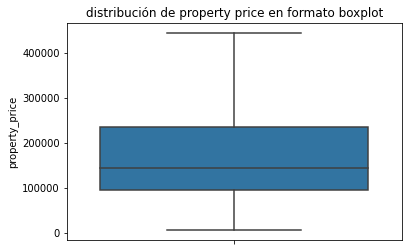

In [517]:
mostrar_medidas_resumen('property_price', show_boxplot=True, df=ds_filtrado, ylabel='property price')

Observamos que el q1 es de aproximadamente 95000. Pensando en los casos reales que conocemos, nos parece un buen limite para poner el maximo de un precio que consideramos bajo. 

Luego, continuando con la distribucion de la variable, nos parece razonable clasificar un precio mediano con valores que ronden desde 95000 (el q1 de la variable) hasta 235000.

Por ultimo, consideramos que los valores superiores a 235000 ya se pueden clasificar como precios altos.

In [518]:
def categorise(row):  
    if row['property_price'] <= 95000:
        return 'low_price'
    elif row['property_price'] > 95000 and row['property_price'] <= 235000:
        return 'medium_price'
    elif row['property_price'] > 235000:
        return 'high_price'


Una vez clasificados los tipos de precio en base a los precios, pasamos a crear la nueva columna.

In [520]:
ds_filtrado['target'] = ds_filtrado.apply(lambda row: categorise(row), axis=1)


,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title,target
42,d3Z0MblSb2IMBoOBMGJEEQ==,2021-09-09,2021-09-26,2021-09-09,-34.637319,-58.361124,Capital Federal,Boca,Venta,Departamento,3.0,2.0,58.000000,55.0,82900.0,USD,VENTA TRES AMBIENTES LA BOCA PISO ALTO,low_price
43,rL7qPkQnomsMGu2ViS3sBw==,2021-09-09,2021-09-28,2021-09-09,-34.628647,-58.361871,Capital Federal,Boca,Venta,Departamento,4.0,3.0,70.000000,70.0,99000.0,USD,Departamento - 4 Ambientes - Catalinas Sur,medium_price
49,vuX/ccLAMVml4qWRFcOJUA==,2021-09-09,2022-01-05,2021-09-09,-34.610027,-58.401934,Capital Federal,Once,Venta,Departamento,4.0,2.0,140.029835,104.0,146000.0,USD,Venta departamento 4 ambientes Once,medium_price
51,ZTtSCeqZ3HUgf5jjwEzRcw==,2021-09-09,2022-03-09,2021-09-09,-34.631621,-58.416825,Capital Federal,Boedo,Venta,PH,4.0,2.0,108.082934,73.0,250000.0,USD,PH - Boedo,high_price
53,3XhGN1xIqtzxywrDb3vC/w==,2021-09-09,2022-01-27,2021-09-09,-34.623886,-58.412746,Capital Federal,Boedo,Venta,PH,2.0,1.0,61.000000,46.0,100000.0,USD,PH 2 Ambientes c/Patio HECHO A NUEVO,medium_price
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460072,v4f5Un9jO7hsD02MWLkKBQ==,2021-01-05,2022-09-02,2021-01-05,-34.603245,-58.489810,Capital Federal,Villa del Parque,Venta,Departamento,4.0,3.0,130.000000,100.0,220000.0,USD,Espectacular 4 amb130m2 con Balcon Terraza!!!,medium_price
460073,Aq/Z+XyS8FHbOOxed4xtTw==,2021-01-05,2021-02-17,2021-01-05,-34.614063,-58.482814,Capital Federal,Villa del Parque,Venta,Departamento,3.0,2.0,68.000000,60.0,161000.0,USD,3 ambientes con cochera listo para habitar!,medium_price
460074,Rmamz8v4Wkh5xF7PA59Jqw==,2021-01-05,2021-01-27,2021-01-05,-34.614175,-58.479062,Capital Federal,Villa del Parque,Venta,Departamento,1.0,1.0,51.000000,30.0,75500.0,USD,VENTA MONOAMBIENTE CON PATIO SOL DE MAÑANA ///...,low_price
460075,7yl8Dfx5wobH21YdMU+Kgg==,2021-01-05,2021-01-27,2021-01-05,-34.614175,-58.479062,Capital Federal,Villa del Parque,Venta,Departamento,1.0,1.0,37.000000,31.0,74500.0,USD,VENTA MONOAMBIENTE APAISADO y DIVISIBLE AL CF ...,low_price


In [521]:
ds_filtrado.target.value_counts()

medium_price    46306
low_price       23619
high_price      23053
Name: target, dtype: int64

In [522]:
from sklearn.model_selection import train_test_split

#Creo un dataset con los features que voy a usar para clasificar
ds_filtrado_x=ds_filtrado.drop(['property_price'], axis='columns', inplace=False)

#Creo un dataset con la variable target
ds_filtrado_y = ds_filtrado['property_price'].copy()

#Genero los conjuntos de train y de test
x_train, x_test, y_train, y_test = train_test_split(ds_filtrado_x,
                                                    ds_filtrado_y,
                                                    stratify=ds_filtrado['target'].values, 
                                                    test_size=0.3,  #proporcion 70/30
                                                    random_state=2) #semilla

In [ ]:
x_train

## Datos Faltantes
---


### Análisis de datos faltantes a nivel columna

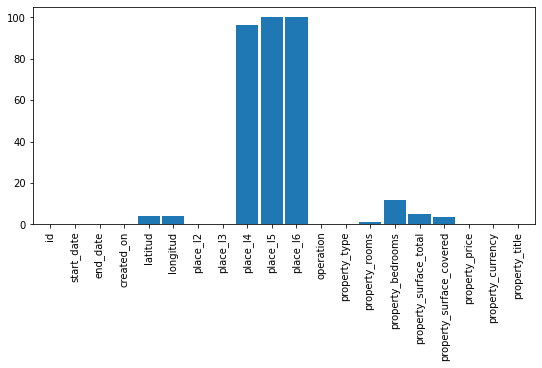

In [428]:
filas_totales = ds_filtrado.shape[0]
(ds_filtrado.isna().sum()/filas_totales*100).plot( kind = 'bar', 
             stacked = 'True',          # Muestra las barras apiladas
             alpha = 1,                 # nivel de transparencia
             width = 0.9,               # Grosor de las barras para dejar espacio entre ellas
             figsize=(9,4));            # Cambiamos el tamaño de la figura

Observamos que place l4 está conformado mayormente por valores vacíos, mientras que l5 y l6 están completamente vacíos. Luego tenemos varias columnas con todos sus valores, y algunas otras con un porcentaje de valores faltantes relativamente bajo.

### Análisis de datos faltantes a nivel fila

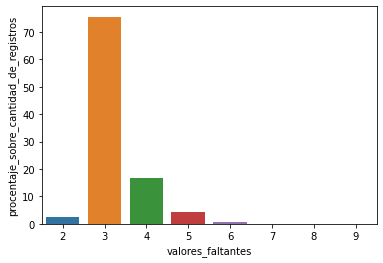

In [429]:
temp = ds_filtrado.isna().sum(axis=1)
temp = temp.value_counts().to_frame("procentaje_sobre_cantidad_de_registros")
temp['valores_faltantes'] = temp.index
temp = temp.reset_index()
temp.procentaje_sobre_cantidad_de_registros = temp.procentaje_sobre_cantidad_de_registros/filas_totales*100
sns.barplot(data=temp, x="valores_faltantes", y="procentaje_sobre_cantidad_de_registros")
plt.show()


Podemos observar que contamos con una amplia cantidad de filas con 3 datos faltantes. Se observan pocas filas con mas de 6 datos faltantes, por lo que podemos asumir por ahora que la gran mayoría de nuestro data set nos brinda al menos mas del 50% de información en cada registro. 

### Reparaciones de Datos Faltantes


In [430]:
(ds_filtrado.isna().sum()/filas_totales*100)

id                            0.000000
start_date                    0.000000
end_date                      0.000000
created_on                    0.000000
latitud                       3.922404
longitud                      3.922404
place_l2                      0.000000
place_l3                      0.429313
place_l4                     96.140448
place_l5                    100.000000
place_l6                    100.000000
operation                     0.000000
property_type                 0.000000
property_rooms                1.104708
property_bedrooms            11.660683
property_surface_total        5.127249
property_surface_covered      3.570858
property_price                0.000000
property_currency             0.000000
property_title                0.000000
dtype: float64

Si bien esta es el porcentaje de datos faltanes NaN, hay otros datos faltantes que son inválidos, y tambien los tenemos en cuenta.

Se observa que las columnas en las que se encuentran datos faltantes son en latitud, longitud, place_l3, place_l4, place_l5, place_l6, property_rooms, property_bedrooms, property_surface_total, y  property_surface_covered.
En esta seccion analizaremos como manejar estos casos especiales. Comenzaremos por la clasificacion de datos faltantes. 

* Missing completly at random:

    No existe relacion entre la falta de datos y la variable donde se encuentra el dato faltante.

* Missing not at random:

    La falta esta asociada a la naturaleza de la variable. Depende precisamente de los mismos datos que recolectamos. 


* Missing at random: 

    La falta no depende de los mismos datos faltantes, sino de otras variables. 


####Eliminacion de datos faltantes

#####place_l5 y place_l6

Se observa que place_l5 y place_l6 son datos faltantes de tipo MCAR ya que la razon de falta de datos es ajena a los datos mismos. Faltan datos en todos los registros, por lo que no se puede hacer ninguna relacion entre estos datos y otras columnas. 

In [431]:
print(ds_filtrado['place_l5'].isna().sum()/filas_totales*100)
print(ds_filtrado['place_l6'].isna().sum()/filas_totales*100)

100.0
100.0


Dado que el porcentaje de datos faltantes es muestra una falta casi por completo de los datos, decimos eliminarlos.

In [432]:
ds_filtrado.drop('place_l5', axis='columns', inplace=True)
ds_filtrado.drop('place_l6', axis='columns', inplace=True)

#####place_l4

In [433]:
print("l4:\n", ds.place_l4.value_counts())
print("\nValores posibles de l4:\n", ds.place_l4.unique())

l4:
 Palermo Hollywood    1559
Palermo Chico        1091
Palermo Soho          802
Palermo Viejo         171
Name: place_l4, dtype: int64

Valores posibles de l4:
 [nan 'Palermo Chico' 'Palermo Soho' 'Palermo Viejo' 'Palermo Hollywood']


Se visualiza que place_l4 solo presenta datos sobre secciones dentro del barrio de Palermo. Si se enlistan los valores posibles en esta variable se aprecia el hecho de que los unicos valores son nan o secciones de Palermo. Por lo que se llega a la conclusion de que los datos faltantes podrian estar relacionados a que dichas celdas no presenten lugares de Palermo. En este caso, se abre la posibilidad de contar con que la variable place_l4 puede contar con datos del tipo MNAR (Missing not at random).  

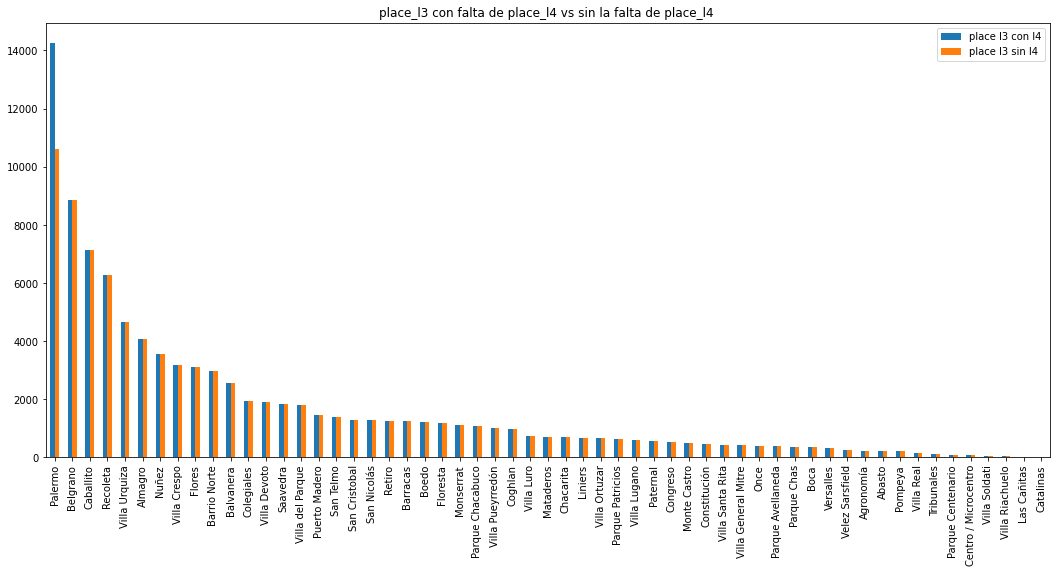

In [434]:
temp = ds_filtrado[ds_filtrado.place_l4.isna()]

plotdata = pd.DataFrame({
    "place l3 con l4":ds_filtrado.place_l3.value_counts(),
    "place l3 sin l4":temp.place_l3.value_counts(),
    }, 
)
plotdata.plot(kind="bar", figsize=(18,8))
plt.title("place_l3 con falta de place_l4 vs sin la falta de place_l4 ")
plt.xlabel = "Place_l3"


Se observa gráficamente que para que se observe un valor no nan en place_l4, place_l3 tiene que ser Palermo. Dado que vemos que aunque place_l3 sea palermo hay un gran procentaje donde falta place_l4, el hecho de que place_l3 sea Palermo es una condición necesaria pero no suficiente para observar place_l4 no nan.


In [435]:
ds_filtrado[ds_filtrado['place_l4'].notna()].place_l3.value_counts()


Palermo    3623
Name: place_l3, dtype: int64

Consideramos que place_l4 nos servia para verificar que la columna referente al barrio(place_l3) estuviera correcta, en este caso que fuera palermo en todas las filas que cuentan con un place_l4 con valor no nulo. 
Habiendo verificado que todas estan en palermo pordemos tomar la decision de que la columna no nos aporta informacion relevante para el dominio de nuestro problema, por lo tanto la eliminamos. 

In [436]:
ds_filtrado.drop('place_l4', axis='columns', inplace=True)

##### latitud y longitud

Analizaremos estos dos datos juntos dado que tienen una relación lógica y tienen además el mismo procentaje de nans.

Primero analizamos si los registros que tienen nan en latitud son los mismos que tienen nan en longitud (y viceversa)

In [437]:
cond_longitud_nan = ds_filtrado['longitud'].isna()
cond_latitud_nan = ds_filtrado['latitud'].isna()
print(ds_filtrado[cond_longitud_nan].shape)
print(ds_filtrado[cond_latitud_nan].shape)
print(ds_filtrado[cond_longitud_nan & cond_latitud_nan].shape)

(3682, 17)
(3682, 17)
(3682, 17)


Observamos que los registros que tienen alguno de los dos datos faltantes, también tiene su par faltante. Con lo cual, tiene sentido analizarlos juntos. Ademas consideramos apropiado clasificar estos datos faltantes, como MAR. Siendo que la falta de uno dependende del otro y viceversa.

Ahora analizaremos si los registros con estos datos faltantes corresponden a un barrio en específico, o si tienen alguna relación con la columna de barrio en general.

In [438]:
registros_sin_coord = ds_filtrado[cond_longitud_nan & cond_latitud_nan]
registros_sin_coord.place_l3.value_counts()

Palermo                 888
Belgrano                646
Nuñez                   228
Recoleta                227
Barrio Norte            185
Caballito               169
Almagro                 159
Villa Urquiza           150
Flores                  115
Villa Crespo            111
San Telmo                95
Balvanera                80
Puerto Madero            65
Coghlan                  47
San Nicolás              46
Congreso                 39
Once                     36
Tribunales               32
Monserrat                27
Retiro                   18
Constitución             14
Barracas                 14
Abasto                   12
Paternal                 10
Colegiales               10
Liniers                  10
Saavedra                  9
Villa del Parque          9
Floresta                  8
Mataderos                 7
Parque Chacabuco          7
San Cristobal             7
Villa Devoto              7
Villa Pueyrredón          5
Villa Lugano              4
Pompeya             

Buscamos ahora cuantos registros no tienen ningún valor respecto a la ubicación:

In [439]:
cond_barrio_nan = ds_filtrado['place_l3'].isna()
# cond_sector_barrial_nan = ds_filtrado['place_l4'].isna()
registros_sin_ubi = ds_filtrado[cond_longitud_nan & cond_latitud_nan & cond_barrio_nan ]#& cond_sector_barrial_nan]
registros_sin_ubi.shape

(157, 17)

Tendría sentido remover estos registros dado que no hay variables con uan relación suficientemente fuerte para poder predecir la ubicación a partir de los otros datos. 

In [440]:
ds_filtrado.drop(registros_sin_ubi.index, inplace=True)

A pesar de haber eliminado parte de los datos faltantes d eestas variables, continuaremos con el tratamiento de los restantes en la seccion de imputacion.

#### start_date, end_date, crated_on

Como vimos en la sección de exploración inicial -> variables cuantitativas -> medidas de resumen, teníamos 5041 registros inválidos de end_date dado que tenían una fecha "9999-12-31". 

Dado que esta fecha esta lejos de cualquier valor válido, no podemos aproximarla o transformarla en una fecha válida. 

#### <font color=red>Fechas

#### Imputacion de datos faltantes

#####property_bedrooms


In [441]:
cond_habitaciones_nan = ds_filtrado['property_bedrooms'].isna()
cond_ambientes_nan = ds_filtrado['property_rooms'].isna()
registros_sin_rooms_ni_bedrooms = ds_filtrado[cond_habitaciones_nan & cond_ambientes_nan]
registros_sin_rooms_ni_bedrooms.shape

(429, 17)

Consideramos que las filas que tienen cantidad de habitaciones y ambientes con valores nan habria que eliminarlas ya que no hay forma de obtener ambos datos con precision de una sin la otra debido a su alta correlacion.

In [442]:
ds_filtrado.drop(registros_sin_rooms_ni_bedrooms.index, inplace=True)

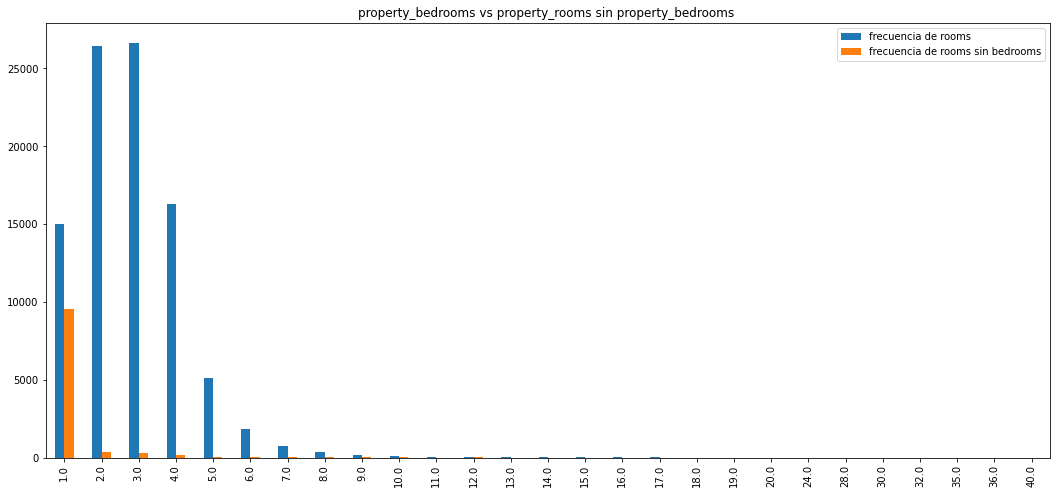

In [443]:
temp_sin_bedrooms = ds_filtrado[ds_filtrado.property_bedrooms.isna()]

plotdata = pd.DataFrame({
    "frecuencia de rooms":ds_filtrado.property_rooms.value_counts(),
    "frecuencia de rooms sin bedrooms":temp_sin_bedrooms.property_rooms.value_counts(),
    }, 
)

plotdata.plot(kind="bar", figsize=(18,8))
plt.title("property_bedrooms vs property_rooms sin property_bedrooms ")
plt.xlabel = "property_rooms"

Del grafico se puede analizar que en la vasta mayoria de los casos donde falta el dato sobre la cantidad de habitaciones es mayoritariamente en el caso de que se trate de monoambientes.

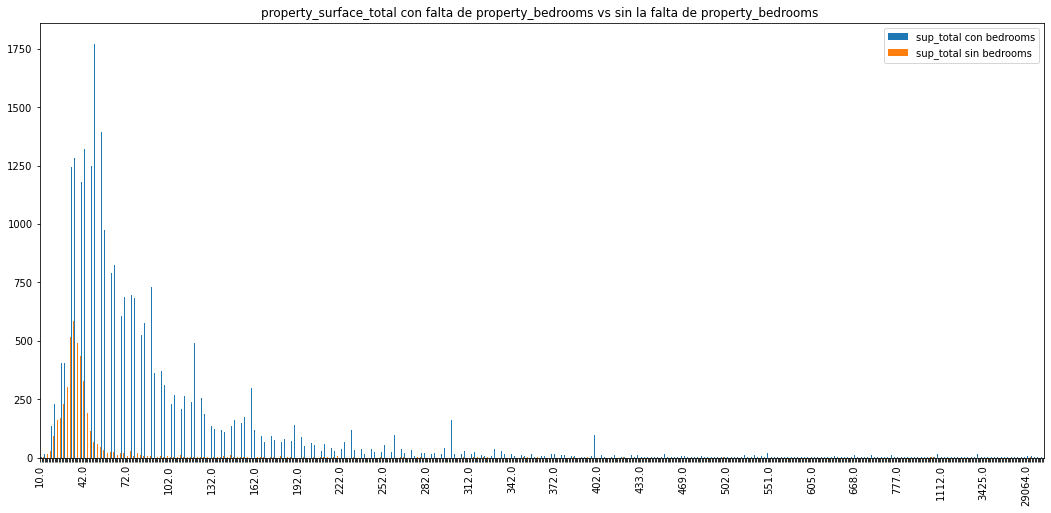

In [444]:
temp_sin_bedrooms = ds_filtrado[ds_filtrado.property_bedrooms.isna()]

plotdata = pd.DataFrame({
    "sup_total con bedrooms":ds_filtrado.property_surface_total.value_counts(),
    "sup_total sin bedrooms":temp_sin_bedrooms.property_surface_total.value_counts(),
    }, 
)
plot_ = plotdata.plot(kind="bar", figsize=(18,8))
plt.title("property_surface_total con falta de property_bedrooms vs sin la falta de property_bedrooms ")
plt.xlabel = "property_surface_total"

for ind, label in enumerate(plot_.get_xticklabels()):
    if ind % 30 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

En este grafico se puede observar que la mayoria de los registros en donde falta property_bedrooms es en las propiedades con superficie mas chica, fortaleciendo asi la hipótesis de que se encuentra una falta de datos en la columna de cantidad de habitaciones al tratarse de monoambientes. 


In [445]:
ds_filtrado[(ds_filtrado['property_rooms']==1)].property_bedrooms.value_counts()

1.0    5476
Name: property_bedrooms, dtype: int64


<font color='red'>los valores atípicos serán tratados en su respectiva sección</font> 


Dado que tener más de 1 habitación en un monoambiente es incoherente, y que la vasta mayoría de los monoambientes que no tienen dato faltante en propert_bedrooms tienen su valor en 1, reemplazamos lo registros monoambientes faltantes con 1 (asumiendo el supuesto de que las propiedades analizadas son hogares). 

Para los casos donde no son monoambientes, cuando predigamos la cantidad de habitaciones, reemplazaremos los 0's por 1's de igual manera mediante el mismo razonamiento. 

In [446]:
columnas = ['property_rooms','property_bedrooms']
ds_property_bedrooms_sin_nan = ds_filtrado[columnas].copy()
cond_monoambiente = ds_property_bedrooms_sin_nan['property_rooms']==1
cond_bedroom_nan = ds_property_bedrooms_sin_nan['property_bedrooms'].isna()
ds_property_bedrooms_sin_nan.loc[cond_monoambiente & cond_bedroom_nan, 'property_bedrooms'] = 1 # reemplazamos monoambientes con bedrooms nan por 1


In [447]:
print('El porcentaje de viviendas con mas de un ambiente (property_rooms) que no tienen habiaciones (property_bedrooms) es:', ds_filtrado['property_bedrooms'].isna().sum()/filas_totales*100)

El porcentaje de viviendas con mas de un ambiente (property_rooms) que no tienen habiaciones (property_bedrooms) es: 11.146147372457946


Por lo tanto, la mayoría de los casos en los cuales faltan habitaciones (property_bedrooms) es en monoambientes. Con lo cual, podemos asumir que los datos faltantes de esta variable son de tipo MAR. 

Para los casos donde se tiene mas de un ambiente, podemos aplicar el imputador iterativo. 

In [448]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

columnas=['property_surface_total','property_surface_covered','property_bedrooms','property_rooms']
df_eliminar_nans_en_bedrooms_y_rooms = ds_filtrado[columnas].copy()

lr = LinearRegression()
imp = IterativeImputer(estimator=lr,missing_values=np.nan, max_iter=20, verbose=0, random_state=2) #imputation_order='roman'
array_sin_nans_en_bedrooms_y_rooms = imp.fit_transform(df_eliminar_nans_en_bedrooms_y_rooms)

In [449]:
ds_sin_nans_en_bedrooms_y_rooms = pd.DataFrame(array_sin_nans_en_bedrooms_y_rooms, columns = columnas) #imp.fit_transfor devuelve un arrar sin nans en las columnas
ds_sin_nans_en_bedrooms_y_rooms = ds_sin_nans_en_bedrooms_y_rooms.round(0)

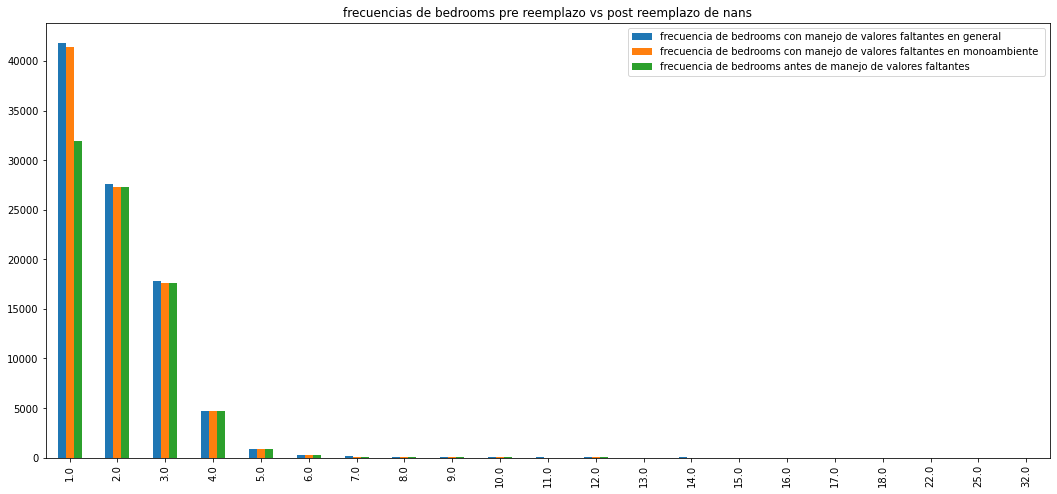

In [450]:
plotdata = pd.DataFrame({
    "frecuencia de bedrooms con manejo de valores faltantes en general":ds_sin_nans_en_bedrooms_y_rooms.property_bedrooms.value_counts(),
    "frecuencia de bedrooms con manejo de valores faltantes en monoambiente ":ds_property_bedrooms_sin_nan.property_bedrooms.value_counts(),
    "frecuencia de bedrooms antes de manejo de valores faltantes":ds_filtrado.property_bedrooms.value_counts(),
    }, 
)

plotdata.plot(kind="bar", figsize=(18,8))
plt.title("frecuencias de bedrooms pre reemplazo vs post reemplazo de nans")
plt.xlabel = "property_bedrooms"

In [451]:
print("Porcentaje de valores nan en property_bedrooms antes de manejar los valores faltantes:", ds_filtrado['property_bedrooms'].isna().sum()/filas_totales*100)

ds_filtrado['property_bedrooms'] = ds_property_bedrooms_sin_nan['property_bedrooms']
ds_filtrado.loc[:,"property_bedrooms"].replace(to_replace=[ds_filtrado['property_bedrooms']],value=[ds_sin_nans_en_bedrooms_y_rooms['property_bedrooms']],inplace=True)

print("Porcentaje de valores nan en property_bedrooms despues de manejar los valores faltantes:", ds_filtrado['property_bedrooms'].isna().sum()/filas_totales*100)

Porcentaje de valores nan en property_bedrooms antes de manejar los valores faltantes: 11.146147372457946
Porcentaje de valores nan en property_bedrooms despues de manejar los valores faltantes: 0.0


##### Latitud y Longitud

In [452]:
cond_longitud_nan = ds_filtrado['longitud'].isna()
cond_latitud_nan = ds_filtrado['latitud'].isna()
print(ds_filtrado[cond_longitud_nan & cond_latitud_nan].shape)

(3462, 17)




Recordamos la cantidad de datos faltantes restantes que hay en estas dos variables, a continuacion efectuamos la imputacion de los datos.

Debido a que latitud y longitud son variables utilizadas para representar una ubicacion en especifico, pensamos en utilizar place_l3 y <font color='red'>place_l4</font> para predecir los valores faltantes siendo que estas tambien representan ubicaciones. Al ser ambas variables categoricas no es posible utilizarlas en <font color='red'>metodos que utilicen regresion lineal. </font> 
Por este motivo, decidimos solo utilizar para predecir el valor de las mismas a property_surface_total y property_price dado que el m^2 en una determinada ubicacion varia con respecto a el de otras. 


A continuacion vamos a hacer el proceso de imputacion de los datos faltantes de latitud y longitud, pero no lo haremos con las dos variables al simultaneo ya que al hacerlo por separado podemos obtener mejores resultados.

In [453]:
ds_a_imputar= ds_filtrado.copy()

In [454]:
columnas=['latitud', 'property_price', 'property_surface_total']
df_eliminar_nans_en_latitud = ds_a_imputar[columnas].copy()

imp = IterativeImputer(missing_values=np.nan, max_iter=20, verbose=0, random_state=2) #imputation_order='roman'
array_sin_nans_en_latitud = imp.fit_transform(df_eliminar_nans_en_latitud)

In [455]:
ds_sin_nans_en_latitud = pd.DataFrame(array_sin_nans_en_latitud, columns = columnas) #imp.fit_transfor devuelve un arrar sin nans en las columnas
ds_a_imputar.loc[:,"latitud"].replace(to_replace=[ds_a_imputar['latitud']],value=[ds_sin_nans_en_latitud['latitud']],inplace=True)

In [456]:
columnas=['latitud','longitud', 'property_price', 'property_surface_total']
df_eliminar_nans_en_latitud_y_longitud = ds_a_imputar[columnas].copy()

array_sin_nans_en_latitud_y_longitud = imp.fit_transform(df_eliminar_nans_en_latitud_y_longitud)

In [457]:
ds_sin_nans_en_latitud_y_longitud = pd.DataFrame(array_sin_nans_en_latitud_y_longitud, columns = columnas) #imp.fit_transfor devuelve un arrar sin nans en las columnas
ds_a_imputar.loc[:,"longitud"].replace(to_replace=[ds_a_imputar['longitud']],value=[ds_sin_nans_en_latitud_y_longitud['longitud']],inplace=True)

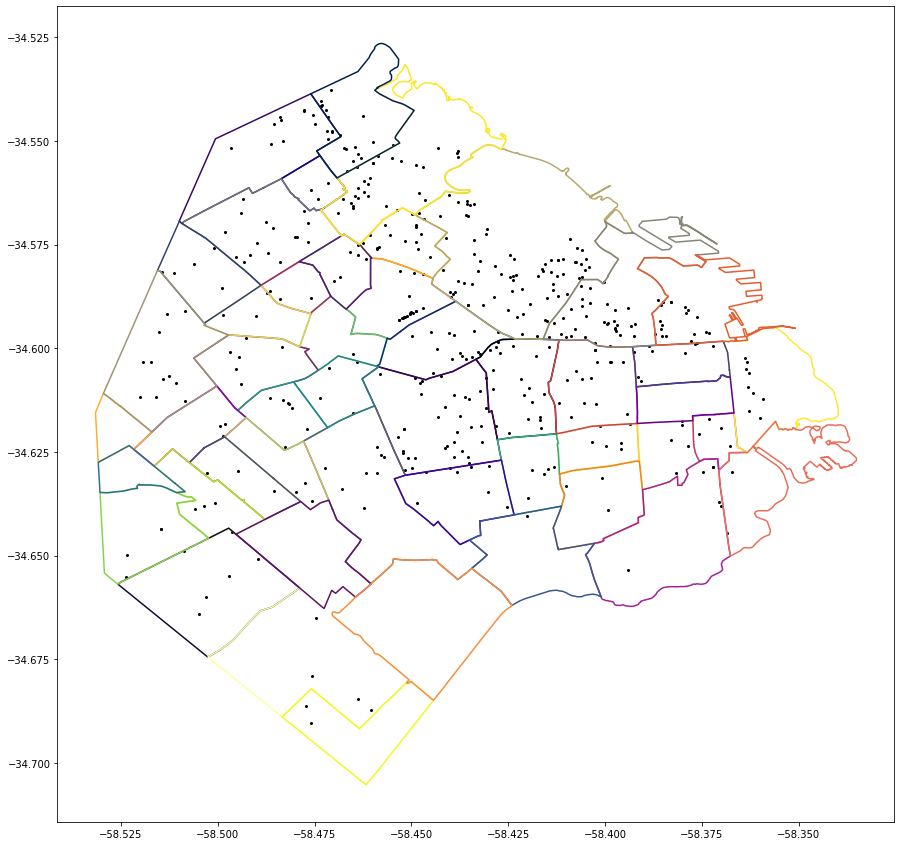

El porcentaje de outsiders dentro de la proporcion pedida de la muestra es: 0.2145922746781116


In [458]:
#accedemos a los indices de las filas que tienen nans
filas=ds_a_imputar[ds_filtrado['longitud'].isna()].index

graficar_puntos_en_caba(ds_sin_nans_en_latitud_y_longitud.longitud, ds_sin_nans_en_latitud_y_longitud.latitud, proporcion=0.005)

In [459]:
#ACA HAY QUE VER SI LAS COORDENADAS QUE PREDIJO EL ALGORITMO PERTENECEN AL PLACE L3 DE LA FILA CORRESPONDIENTE

<font color=red>LUEGO COMPLETAR EL DS_FILTRADO</font>

#####place_l3

In [460]:
print("cantidad de registros place_l3 nulos:", ds_filtrado.place_l3.isna().sum())

cantidad de registros place_l3 nulos: 246


In [461]:
cond_barrio_nan = ds_filtrado['place_l3'].isna()
# cond_sector_barrial_nan = ds_filtrado['place_l4'].isna()
registros_sin_ubi = ds_filtrado[cond_barrio_nan]
registros_sin_ubi.shape

(246, 17)

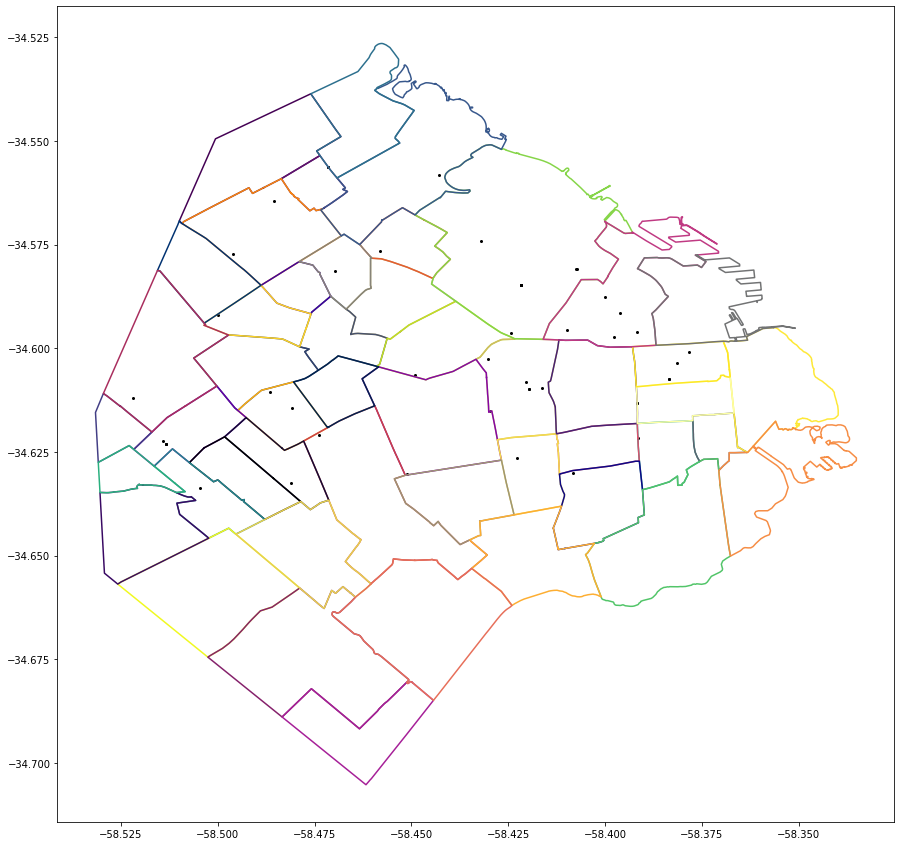

El porcentaje de outsiders dentro de la proporcion pedida de la muestra es: 79.26829268292683


In [462]:
graficar_puntos_en_caba(registros_sin_ubi.longitud, registros_sin_ubi.latitud, proporcion=1)

Observando las latitudes y longitudes de los registros de los cuales place_l3 sus valores son nan, notamos que sus respectivas coordenadas se encuentran fuera de los limites de Capital Federal. Acontinuacion analizaremos como manejar estas incongruencias.

<font color='red'>CREEMOS QUE EL 80% QUE NO ESTA EN CABA HAY QUE ELIINARLO PERO TENEMOS QUE JUSTIFICAR BIEN. EL 20% QUE ESTA EN CABA HAY QUE, EN BASE A LA LAT Y LONG DETERMINAR EL PLACE_L3 MEDIANTE EL GRAFIQUITO. LUCIANO DIBUJE MAESTRO.</font> 

#####property_rooms

In [463]:
print("Cantidad de valores faltantes de property_rooms:",ds_filtrado['property_rooms'].isna().sum())

Cantidad de valores faltantes de property_rooms: 578


Consideramos que podemos utilizar un metodo de regresion lineal para llenar los datos nan de property_rooms. Debido a la fuerte correlacion observada en la matriz de correlaciones, entre esta variable con property_bedrooms, decidimos utilizar esa columna para el entrenamiento de este modelo.


In [464]:
# Guardamos un auxiliar de las dos columnas a tratar
ds_aux = ds_filtrado[['property_rooms', 'property_bedrooms']].copy()
ds_aux = ds_aux.query('property_rooms  > 0')
ds_aux.shape

(92707, 2)

In [465]:
modelo_lineal_rooms = LinearRegression()

#Doy el formato adecuado a las variables dependiente e independiente
bedrooms=ds_aux['property_bedrooms'].values.reshape(-1, 1)
rooms=ds_aux['property_rooms'].values.reshape(-1, 1)

#Ajusto el modelo
modelo_lineal_rooms.fit(bedrooms, rooms)

#Coeficientes Estimados
intercepcion=round(modelo_lineal_rooms.intercept_[0],2)
coef_bedroom=round(modelo_lineal_rooms.coef_[0][0],2)

#Muestro el modelo
print(f" El modelo lineal simple ajustado es: rooms = {coef_bedroom} * bedrooms  + {intercepcion}")

 El modelo lineal simple ajustado es: rooms = 1.25 * bedrooms  + 0.46


In [466]:
rooms_estim_segun_bedrooms= coef_bedroom * bedrooms + intercepcion

ds_aux['rooms_estimadas_bedrooms']= coef_bedroom * bedrooms + intercepcion #Lo agregamos en el dataframe
ds_aux.head()

,property_rooms,property_bedrooms,rooms_estimadas_bedrooms
42,3.0,2.0,2.96
43,4.0,3.0,4.21
49,4.0,2.0,2.96
51,4.0,2.0,2.96
53,2.0,1.0,1.71


Siendo que las variables de room son de tipo entera, debemos redondear los resultados.

In [467]:
ds_aux = ds_aux.round(0) #los resultados deben ser numeros enteros

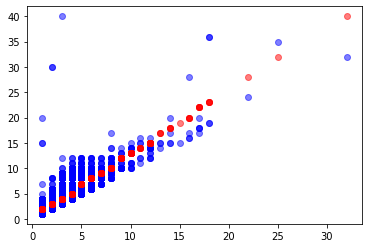

In [468]:
plt.scatter(ds_filtrado['property_bedrooms'],ds_filtrado['property_rooms'],color='blue',alpha=0.5)
plt.scatter(ds_aux['property_bedrooms'],ds_aux['rooms_estimadas_bedrooms'], color='red',alpha=0.5)

In [469]:
ds_antes_de_imputar = ds_filtrado.copy()

In [470]:
#ahora calculo los valores de las rooms en base a las bedrooms
bedrooms_con_rooms_nan = ds_filtrado[ds_filtrado['property_rooms'].isna()]['property_bedrooms']
bedrooms_con_rooms_nan = bedrooms_con_rooms_nan.values.reshape(-1, 1)

rooms_estimadas_segun_bedrooms = modelo_lineal_rooms.predict(bedrooms_con_rooms_nan) #prediccion de valores
rooms_estimadas_segun_bedrooms = rooms_estimadas_segun_bedrooms.round(0)

ds_antes_de_imputar.loc[ds_antes_de_imputar['property_rooms'].isnull(), 'property_rooms'] = rooms_estimadas_segun_bedrooms

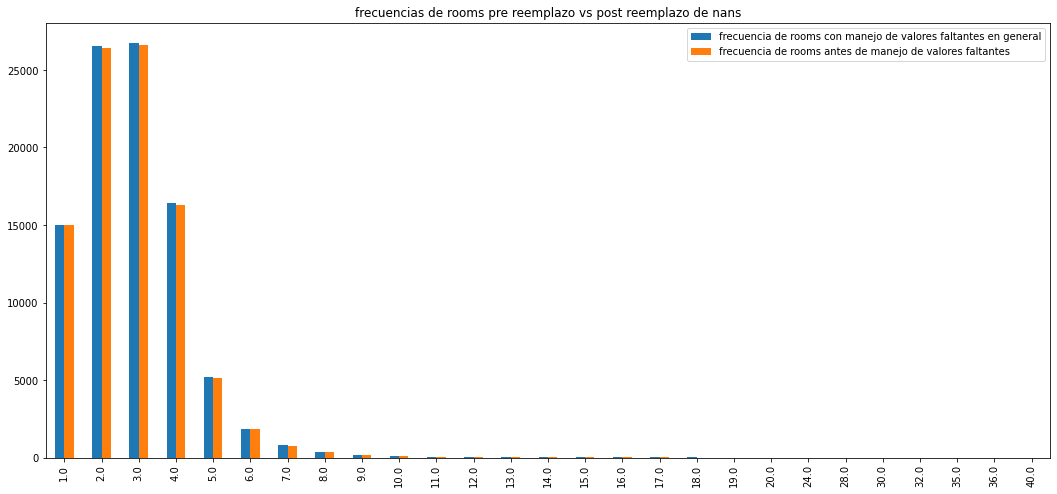

In [471]:
plotdata = pd.DataFrame({
    "frecuencia de rooms con manejo de valores faltantes en general":ds_antes_de_imputar['property_rooms'].value_counts(),
    "frecuencia de rooms antes de manejo de valores faltantes":ds_filtrado['property_rooms'].value_counts(),
    }, 
)

plotdata.plot(kind="bar", figsize=(18,8))
plt.title("frecuencias de rooms pre reemplazo vs post reemplazo de nans")
plt.xlabel = "property_rooms"

In [472]:
# remplazo de columna property_rooms
ds_filtrado.loc[:,"property_rooms"].replace(to_replace=[ds_filtrado['property_rooms']],value=[ds_antes_de_imputar['property_rooms']],inplace=True)

#####property_surface_total

Dado que property_surface_total y property_surfae_covered tienen una alta correlacion, analizamos los casos en los cuales ambas variables tiene valores nan.

In [473]:
cond_superficie_total_nan = ds_filtrado['property_surface_total'].isna()
cond_superfice_cubierta_nan = ds_filtrado['property_surface_covered'].isna()
registros_sin_superficie_cubierta_ni_total = ds_filtrado[cond_superficie_total_nan & cond_superfice_cubierta_nan]
registros_sin_superficie_cubierta_ni_total.shape

(0, 17)

Como ningun registro tiene ambas variables con valor en nan, no eliminamos ningun registro. 

In [474]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

columnas=['property_surface_total','property_surface_covered','property_rooms']
df_eliminar_nans_en_sup_total_y_cubierta = ds_filtrado[columnas].copy()

lr = LinearRegression()
imp = IterativeImputer(estimator=lr,missing_values=np.nan, max_iter=20, verbose=0, random_state=2) #imputation_order='roman'
array_sin_nans_en_sup_total_y_cubierta = imp.fit_transform(df_eliminar_nans_en_sup_total_y_cubierta)

In [475]:
ds_sin_nans_en_sup_total_y_cubierta = pd.DataFrame(array_sin_nans_en_sup_total_y_cubierta, columns = columnas) #imp.fit_transfor devuelve un arrar sin nans en las columnas

<Figure size 432x288 with 0 Axes>

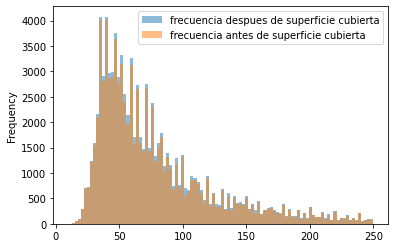

In [476]:
ds_sin_nans_acotado = ds_sin_nans_en_sup_total_y_cubierta.query('property_surface_total < 250')
ds_filtrado_acotado = ds_filtrado.query('property_surface_total < 250')

plotdata = pd.DataFrame({
    "frecuencia despues de superficie cubierta":ds_sin_nans_acotado.property_surface_total,
   "frecuencia antes de superficie cubierta":ds_filtrado_acotado.property_surface_total,
    }, 
)

plt.figure()
plotdata.plot.hist(alpha=0.5, bins = 100)

Decidimos acotar los valores de los registros property_surface_total dado que observamos que con valores mayores a 250 la cantidad de regitros era minima y no se apreciaba completamente el grafico.  

In [477]:
print("Porcentaje de valores nan en property_surface_total antes de manejar los valores faltantes:", ds_filtrado['property_surface_total'].isna().sum()/filas_totales*100)

ds_filtrado.loc[:,"property_surface_total"].replace(to_replace=[ds_filtrado['property_surface_total']],value=[ds_sin_nans_en_sup_total_y_cubierta['property_surface_total']],inplace=True)

print("Porcentaje de valores nan en property_surface_total despues de manejar los valores faltantes:", ds_filtrado['property_surface_total'].isna().sum()/filas_totales*100)

Porcentaje de valores nan en property_surface_total antes de manejar los valores faltantes: 4.966390045914074
Porcentaje de valores nan en property_surface_total despues de manejar los valores faltantes: 0.0


#####property_surface_covered

Como property_surface_covered esta fuertemente correlacionado con property_surface_total utilizamos los mismos datos obtenidos en el manejo de valores faltantes de property_surface_total para imputar los datos faltantes de porperty_surface_covered. Para ello utilizamos el dataset generado anteriormente en la seccion property_surface_total.

<Figure size 432x288 with 0 Axes>

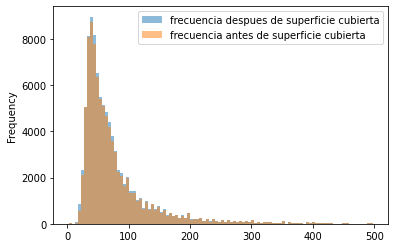

In [478]:
ds_sin_nans_acotado = ds_sin_nans_en_sup_total_y_cubierta.query('property_surface_covered < 500')
ds_filtrado_acotado = ds_filtrado.query('property_surface_covered < 500')

plotdata = pd.DataFrame({
    "frecuencia despues de superficie cubierta":ds_sin_nans_acotado.property_surface_covered,
   "frecuencia antes de superficie cubierta":ds_filtrado_acotado.property_surface_covered,
    }, 
)

plt.figure()
plotdata.plot.hist(alpha=0.5, bins = 100)

#Ver grafico, sacamos el value_counts en pd.DataFrame

In [479]:
print("Porcentaje de valores nan en property_surface_covered antes de manejar los valores faltantes:", ds_filtrado['property_surface_covered'].isna().sum()/filas_totales*100)

ds_filtrado.loc[:,"property_surface_covered"].replace(to_replace=[ds_filtrado['property_surface_covered']],value=[ds_sin_nans_en_sup_total_y_cubierta['property_surface_covered']],inplace=True)

print("Porcentaje de valores nan en property_surface_covered despues de manejar los valores faltantes:", ds_filtrado['property_surface_covered'].isna().sum()/filas_totales*100)

Porcentaje de valores nan en property_surface_covered antes de manejar los valores faltantes: 3.5090709590821447
Porcentaje de valores nan en property_surface_covered despues de manejar los valores faltantes: 0.0


##Valores Atípicos
---


### Análisis univariados


In [480]:
def mostrar_atipicos_univariados(columna):
  sns.boxplot(y=columna)
  #Cuartiles
  Q1_altura=np.quantile(columna, 0.25)
  Q3_altura=np.quantile(columna, 0.75)

  #Rango intercuartil
  IQR_altura=Q3_altura-Q1_altura

  #calculo outliers moderados:
  out_inf=Q1_altura-1.5*IQR_altura
  out_sup=Q3_altura+1.5*IQR_altura

  print("limite moderado inferior:", out_inf)
  print("limite moderado superior:", out_sup)


  print("outliers por debajo de limite moderado", columna[(columna < out_inf)].size)
  print("outliers por arriba de limite moderado", columna[(columna > out_sup)].size)


  #Limite inferior Outliers
  out_inf=Q1_altura-3*IQR_altura
  out_sup=Q3_altura+3*IQR_altura

  print("limite severo inferior:", out_inf)
  print("limite severo superior:", out_sup)

  print("outliers por debajo de limite severo", columna[(columna < out_inf)].size)
  print("outliers por arriba de limite severo", columna[(columna > out_sup)].size)

  


####property_price

limite moderado inferior: -115000.0
limite moderado superior: 445000.0
outliers por debajo de limite moderado 0
outliers por arriba de limite moderado 8383
limite severo inferior: -325000.0
limite severo superior: 655000.0
outliers por debajo de limite severo 0
outliers por arriba de limite severo 4183


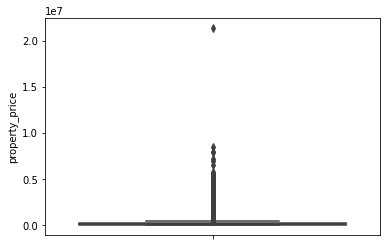

In [481]:
mostrar_atipicos_univariados(ds_filtrado.property_price)

Estos resultados tienen sentido dado que no vemos ningún precio por debajo de 0, mientras que podemos observar precios de hogares que se son mucho mas altos que los límites brindados por el método IRQ.

####property_surface_total

limite moderado inferior: -45.745281788221774
limite moderado superior: 196.24213631370296
outliers por debajo de limite moderado 0
outliers por arriba de limite moderado 7753
limite severo inferior: -136.49056357644355
limite severo superior: 286.98741810192473
outliers por debajo de limite severo 0
outliers por arriba de limite severo 3388


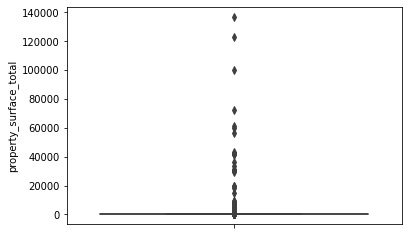

In [482]:
mostrar_atipicos_univariados(ds_filtrado.property_surface_total)

Estos resultados tienen sentido dado que no vemos ninguna medida de superficie por debajo de 0, mientras que podemos observar superficies que son mucho mas altos que los límites brindados por el método IRQ.

####property_surface_covered

limite moderado inferior: -32.0
limite moderado superior: 160.0
outliers por debajo de limite moderado 0
outliers por arriba de limite moderado 7494
limite severo inferior: -104.0
limite severo superior: 232.0
outliers por debajo de limite severo 0
outliers por arriba de limite severo 3333


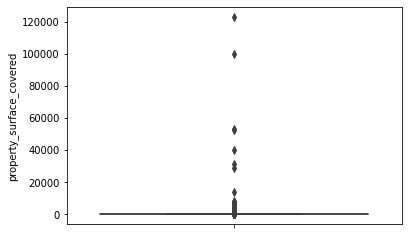

In [483]:
mostrar_atipicos_univariados(ds_filtrado.property_surface_covered)

idem anteriores


####property_bedrooms

limite moderado inferior: -2.0
limite moderado superior: 6.0
outliers por debajo de limite moderado 0
outliers por arriba de limite moderado 265
limite severo inferior: -5.0
limite severo superior: 9.0
outliers por debajo de limite severo 0
outliers por arriba de limite severo 76


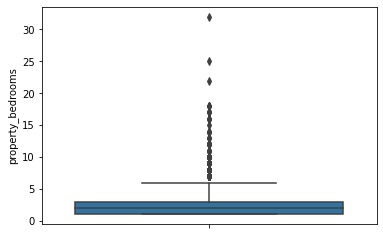

In [484]:
mostrar_atipicos_univariados(ds_filtrado.property_bedrooms)

####property_rooms

limite moderado inferior: -1.0
limite moderado superior: 7.0
outliers por debajo de limite moderado 0
outliers por arriba de limite moderado 778
limite severo inferior: -4.0
limite severo superior: 10.0
outliers por debajo de limite severo 0
outliers por arriba de limite severo 138


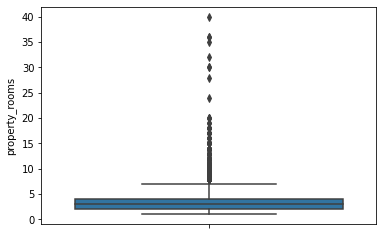

In [485]:
mostrar_atipicos_univariados(ds_filtrado.property_rooms)

Como podemos observar, en la mayoría de los datos tenemos un rango bastante acotado de valores comunes, y los outliers se alejan en gran medida de ese rango acotado. Por eso es que en los gráficos de boxplot, con suerte se llega a ver el rango común.

### Análisis bivariados


In [486]:
from sklearn.utils.fixes import scipy
def mostrar_atipicos_bivariados(columna_a, columna_b):
  sns.scatterplot(x=columna_a, y=columna_b)

# el umbral es a mano, viendo lo que mas sentido tenga
def analisis_mahalanobis(columnas, umbral, cantGraficos = 2):

  X = ds_filtrado[columnas]
  sample_X = X.sample(frac=0.1, random_state=2)

  mu = sample_X.mean()
  X_diff = X - mu
  X_diff = X_diff.values.T

  cov = np.cov(sample_X.values.T)
  inv_cov = np.linalg.inv(cov)
  W = scipy.linalg.sqrtm(inv_cov)

  Wx = np.matmul(W, X_diff)

  mahal_dists = np.array([np.dot(Wx[:, i], Wx[:, i]) for i in range(Wx.shape[1])])
 
  ds_mahal = ds_filtrado[columnas].copy()
  ds_mahal['mahalanobis'] = mahal_dists

  np.sort(ds_mahal)

  ds_mahal['es_outlier'] = ds_mahal['mahalanobis']>umbral

  if(cantGraficos > 1):
    ds_temp = ds_mahal.copy()
    distancia_menor_a_10 = ds_temp['mahalanobis'] < 15
    ds_temp = ds_temp[distancia_menor_a_10]
    print(ds_temp['es_outlier'].value_counts())
    mostrar_distribuciones_cuantitativas("mahalanobis", ds=ds_temp, figsize=(8, 8), bins=30, espaciado=2)
    if len(columnas) == 2:
      plt.figure(figsize=(8, 8), dpi=80)
      sns.scatterplot(x=ds_mahal[columnas[0]], y=ds_mahal[columnas[1]], hue=ds_mahal['es_outlier'])
      mostrar_metadata_grafico(f'Dispersograma {columnas[0]} vs {columnas[1]}')
  else:
    plt.figure(figsize=(8, 8), dpi=80)
    sns.scatterplot(x=ds_mahal[columnas[0]], y=ds_mahal[columnas[1]], hue=ds_mahal['es_outlier'])
    mostrar_metadata_grafico(f'Dispersograma {columnas[0]} vs {columnas[1]}')

####start_date vs end_date

In [487]:
#VER ESTO #mostrar_atipicos_bivariados(ds_filtrado.start_date, ds_filtrado.end_date)

#### property_rooms vs property_bedrooms

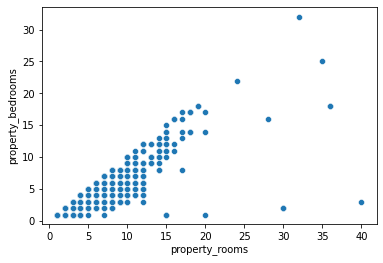

In [488]:
mostrar_atipicos_bivariados(ds_filtrado.property_rooms, ds_filtrado.property_bedrooms)

False    90230
True      2028
Name: es_outlier, dtype: int64


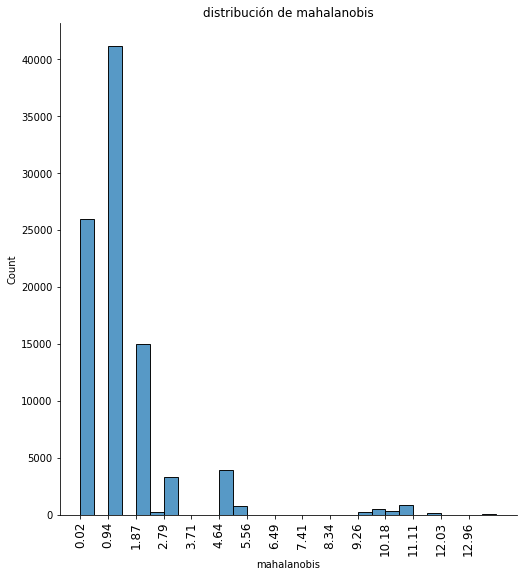

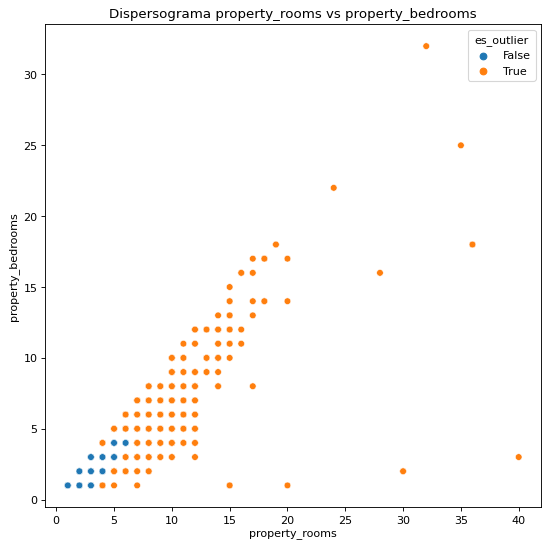

In [489]:
analisis_mahalanobis(['property_rooms', 'property_bedrooms'], 7)

Como podemos observar del grafico de distribución de distancias mahalanobis, vemos que un umbral razonable es 7, dado que a partir de ahí las distancias grandes son anomalías. 
También podemos observar que de los 92000 registros, 2000 salieron como outliers, lo cual es bastante razonable. En el gráfico no parece que sean pocos, pero esto es debido a que la mayoría de los no outliers, se concentran en la esquina inferior izquierda, llevando el valor medio a esa área.

En este caso, proponemos eliminar aquellos outliers que cuentan con una amplia cantidad de ambientes y cuya cantidad de cuartos no es acorde lógicamente a ese número. 
Visualizando el scatterplot, tomamos como umbral de property_bedrooms <= cte * property_rooms siendo cte = 8/17 

In [490]:
cond_menos_bedrooms_que_rooms = ds_filtrado['property_bedrooms'] <= 8/12*(ds_filtrado['property_rooms']) - 10/3

reg_menos_bed_que_rooms = ds_filtrado[cond_menos_bedrooms_que_rooms]
reg_menos_bed_que_rooms.shape

ds_filtrado.drop(reg_menos_bed_que_rooms.index, inplace=True)

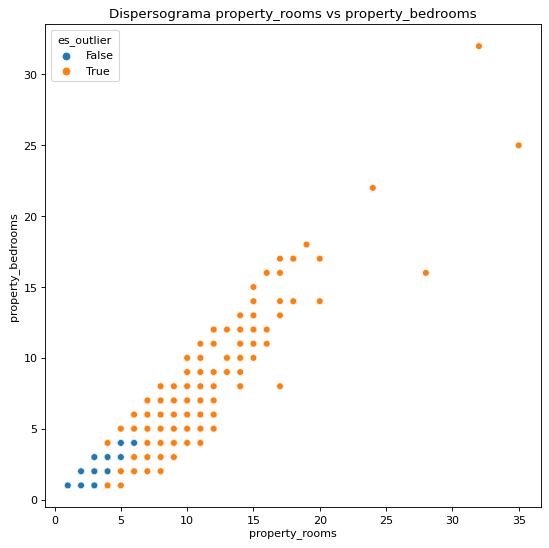

In [491]:
analisis_mahalanobis(['property_rooms', 'property_bedrooms'], 7, 1)

####property_surface_total vs property_surface_covered


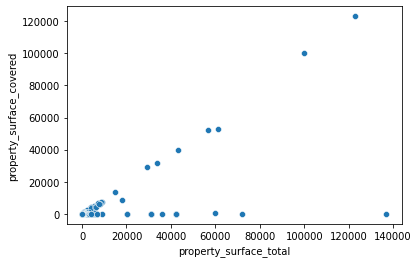

In [492]:
mostrar_atipicos_bivariados(ds_filtrado.property_surface_total, ds_filtrado.property_surface_covered)

False    93174
True        58
Name: es_outlier, dtype: int64


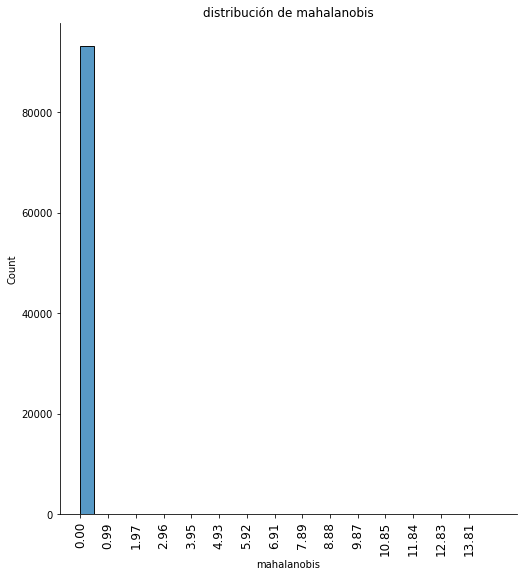

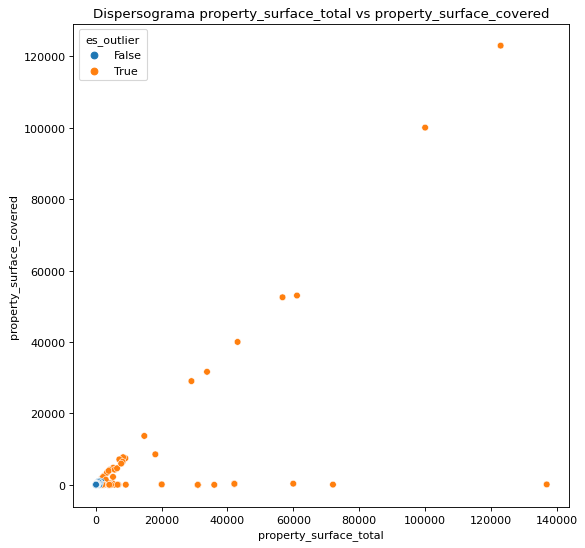

In [493]:
analisis_mahalanobis(['property_surface_total', 'property_surface_covered'], 1)

En este caso, vemos del grafico de distribución de distancias mahalanobis, que un umbral razonable seria 1, dado que a partir de ahí las distancias grandes comienzan a ser anomalías. 

Como analisis logico nos parece razonable destacar el hecho de que es muy poco probable tener Casa, PH o Departamentos que cuenten con mas de 2000 m2 en superficies cubiertas o totales en Capital Federal. Decidimos analizar cuantos casos tienen estas caracteristicas.


In [494]:
cant = ds_filtrado[(ds_filtrado['property_surface_covered'] > 2000) | (ds_filtrado['property_surface_total'] > 2000)].shape[0]
total = ds_filtrado.shape[0]
cant*100/total


0.08898800270180442

Vemos que la proporcion de datos con esas caracteristicas es muy poca a comparacion con la totalidad de los registros. Decidimos eliminar los datos al considerarlos logicamente invalidos. 

In [495]:
cond_surface_total = ds_filtrado['property_surface_total'] > 2000
cond_surface_covered = ds_filtrado['property_surface_covered'] > 2000

reg_combinacion = ds_filtrado[cond_surface_total | cond_surface_covered]
reg_combinacion.shape

ds_filtrado.drop(reg_combinacion.index, inplace=True)

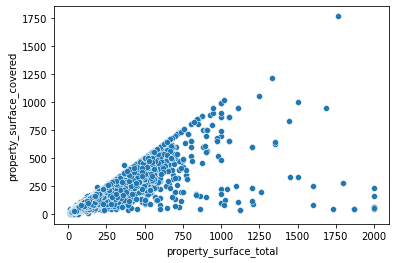

In [496]:
mostrar_atipicos_bivariados(ds_filtrado.property_surface_total, ds_filtrado.property_surface_covered)

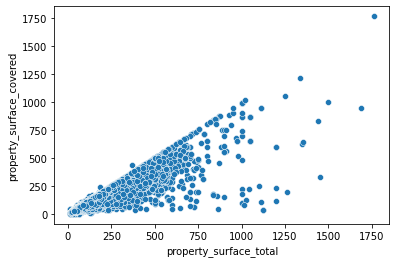

In [497]:
cond_mucho_total_poco_covered = ds_filtrado['property_surface_covered'] <= 13/15*(ds_filtrado['property_surface_total']) -2860/3

reg_mucho_total_poco_covered = ds_filtrado[cond_mucho_total_poco_covered]
reg_mucho_total_poco_covered.shape

ds_aux=ds_filtrado.drop(reg_mucho_total_poco_covered.index, inplace=False)
mostrar_atipicos_bivariados(ds_aux.property_surface_total, ds_aux.property_surface_covered)

<font color=red>verificar la recta elegida para eliminar el grupito de outliers

False    90357
True      1008
Name: es_outlier, dtype: int64


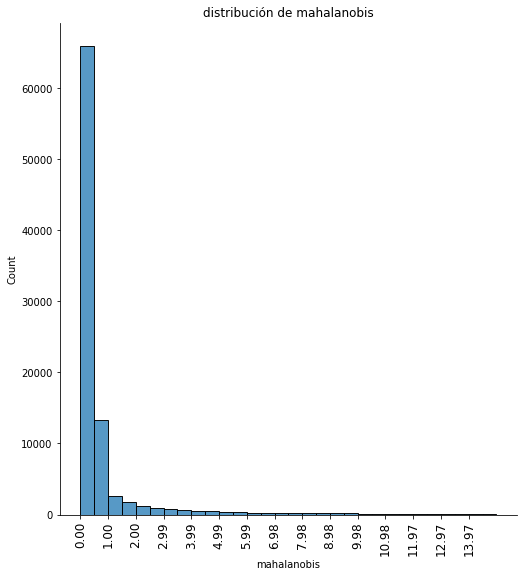

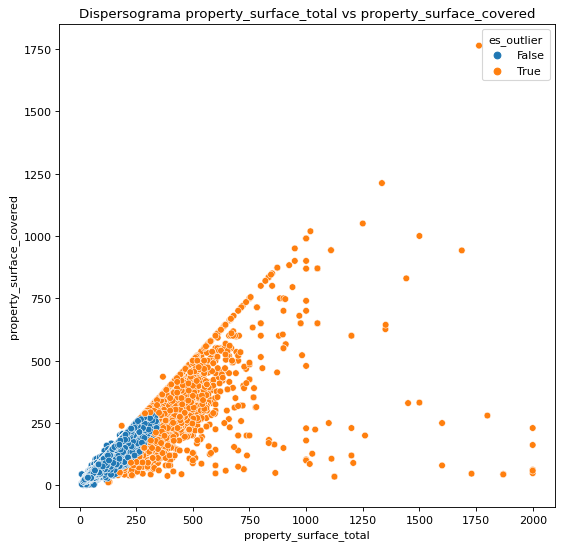

In [498]:
analisis_mahalanobis(['property_surface_total', 'property_surface_covered'], 9.9)

#### property_surface_covered vs property_rooms

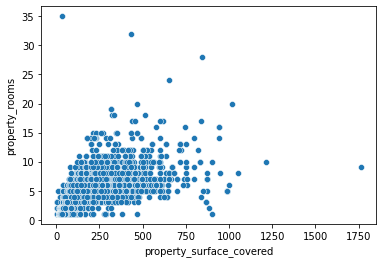

In [499]:
mostrar_atipicos_bivariados(ds_filtrado.property_surface_covered, ds_filtrado.property_rooms)

False    89632
True      1752
Name: es_outlier, dtype: int64


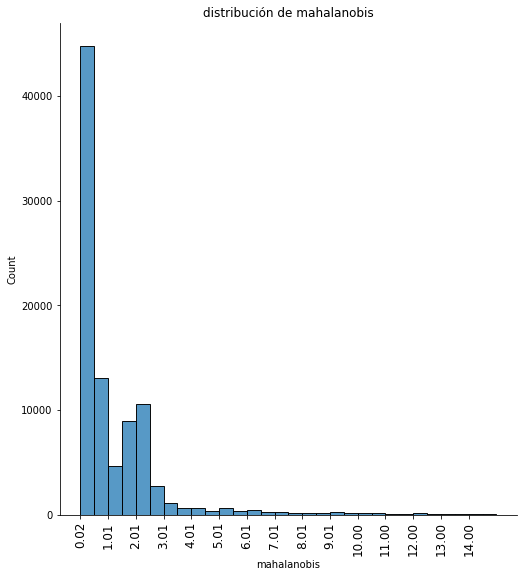

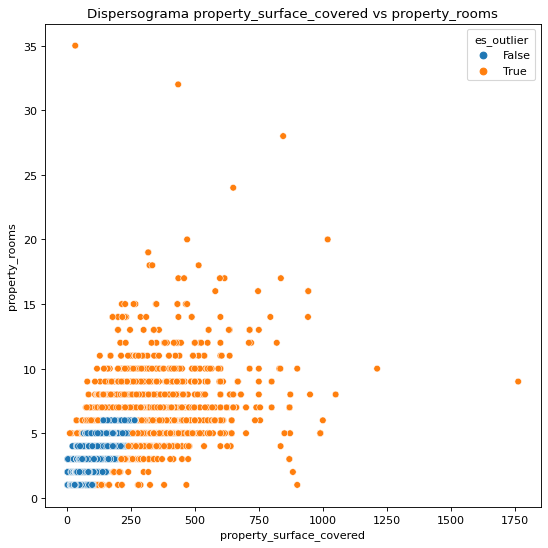

In [500]:
analisis_mahalanobis(['property_surface_covered', 'property_rooms'], 7.9)

En este caso, vemos del grafico de distribución de distancias mahalanobis, que un umbral razonable seria 7.9, dado que a partir de ahí las distancias grandes son anomalías. También podemos observar que solo 1750 casos salieron como outliers, del total de los datos, lo cual es bastante razonable, siendo esta una proporcion baja. 

En el gráfico no parece que sean pocos, pero esto es debido a que la mayoría de los no outliers, se concentran en la esquina inferior izquierda, llevando el valor medio a esa área.

In [501]:
cond_property_rooms = ds_filtrado['property_rooms'] > 13
cond_surface_covered = ds_filtrado['property_surface_covered'] > 650

reg_combinacion = ds_filtrado[cond_property_rooms | cond_surface_covered]
reg_combinacion.shape

ds_filtrado.drop(reg_combinacion.index, inplace=True)

False    88824
True      2364
Name: es_outlier, dtype: int64


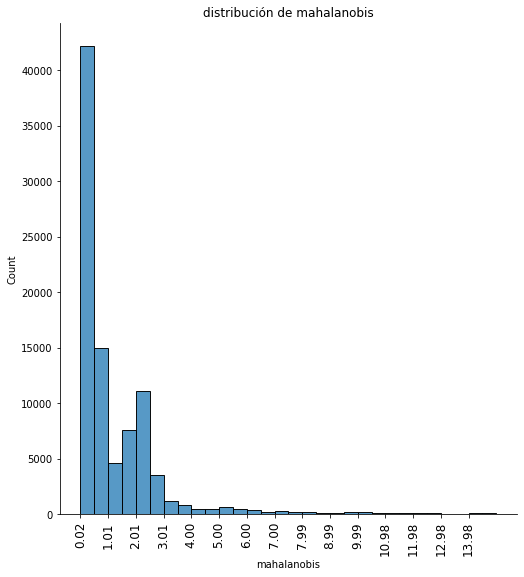

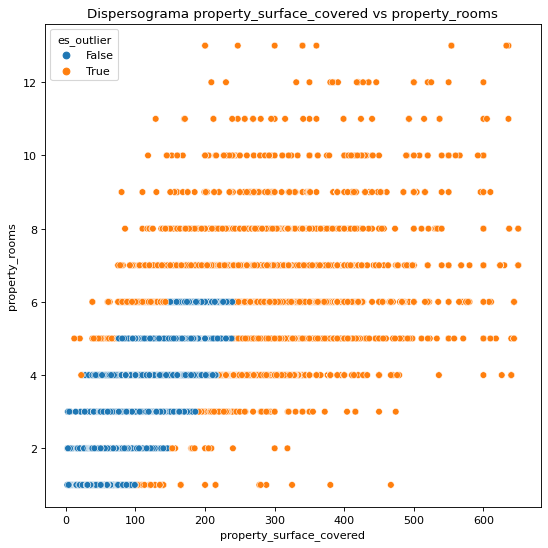

In [502]:
analisis_mahalanobis(['property_surface_covered', 'property_rooms'], 7)

En este caso, vimos conveniente eliminar aquellos registros que tienen valores de property_rooms y property_surface_covered poco probables. Por ejemplo, tener 700 m^2 contra 10 cuartos. 

####property_price vs property_rooms (creemos que vuela)

In [503]:
#mostrar_atipicos_bivariados(ds_filtrado.property_price, ds_filtrado.property_rooms)

In [504]:
#analisis_mahalanobis(['property_price', 'property_rooms'], 8)

En este caso, vemos del grafico de distribución de distancias mahalanobis, que un umbral razonable seria 8, dado que a partir de ahí las distancias grandes son anomalías. También podemos observar que solo 1436 casos salieron como outliers, del total de los datos, lo cual es bastante razonable, siendo esta una proporcion baja. En el gráfico no parece que sean pocos, pero esto es debido a que la mayoría de los no outliers, se concentran en la esquina inferior izquierda, llevando el valor medio a esa área.

####property_price vs property_surface_total

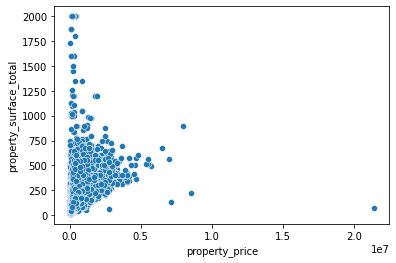

In [505]:
mostrar_atipicos_bivariados(ds_filtrado.property_price, ds_filtrado.property_surface_total)

False    88323
True      2607
Name: es_outlier, dtype: int64


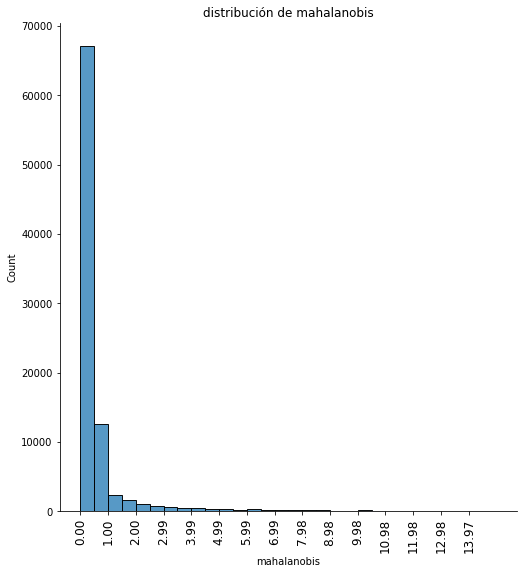

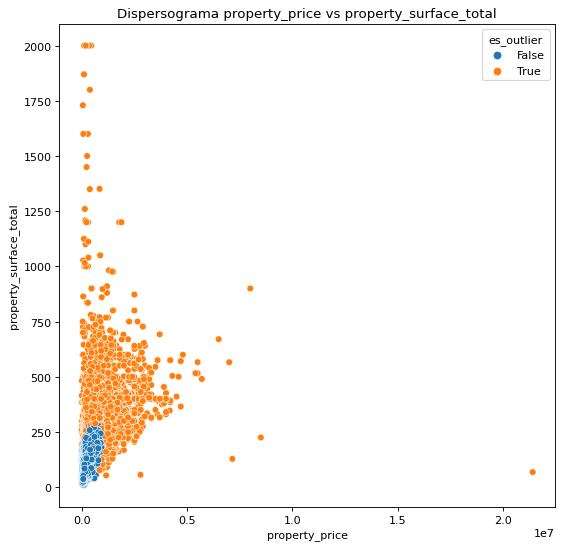

In [506]:
analisis_mahalanobis(['property_price', 'property_surface_total'], 6)

En este caso, vemos del grafico de distribución de distancias mahalanobis, que un umbral razonable seria 6, dado que a partir de ahí las distancias grandes son anomalías. También podemos observar que solo 2563 casos salieron como outliers, del total de los datos, lo cual es bastante razonable, siendo esta una proporcion baja. 

En el gráfico no parece que sean pocos, pero esto es debido a que la mayoría de los no outliers, se concentran en la esquina inferior izquierda, llevando el valor medio a esa área.

En este caso, vimos conveniente eliminar aquellos registros que tienen valores de property_price y property_surface_total muy poco probables.

In [507]:
cond_property_price = ds_filtrado['property_price'] > 4000000
cond_surface_total = ds_filtrado['property_surface_total'] > 750

reg_combinacion = ds_filtrado[cond_property_price | cond_surface_total]
reg_combinacion.shape

ds_filtrado.drop(reg_combinacion.index, inplace=True)

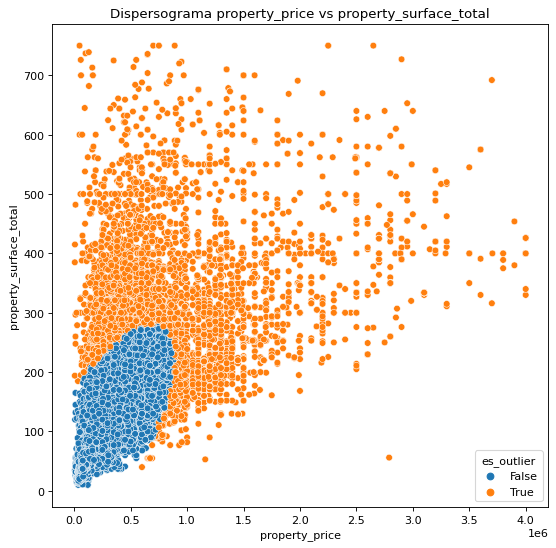

In [508]:
analisis_mahalanobis(['property_price', 'property_surface_total'], 6, 1)

##Reducción de la dimensionalidad

In [509]:
ds_aux = ds_filtrado.drop(columns = ['latitud','longitud','place_l2', 'id', 'place_l3', 'operation', 'property_type', 'property_title', 'end_date', 'created_on', 'start_date', 'property_currency'], inplace=False)
columnas_elegidas = ds_aux.columns.to_list()


x = ds_aux.loc[:, columnas_elegidas]

x = StandardScaler().fit_transform(x)
# print(x)

from sklearn.decomposition import PCA

pca = PCA(n_components=3) #Luego veremos como determinar la cantidad de componentes
x_transformada = pca.fit_transform(x)

pca_ds_aux = pd.DataFrame(data = x_transformada
             , columns = ['cp_1', 'cp_2','cp_3'])

print(pca_ds_aux)


           cp_1      cp_2      cp_3
0     -0.456499 -0.594011 -0.150423
1      0.523302 -1.323474 -0.450031
2      0.846066 -0.452486  0.489815
3      0.559118 -0.350869 -0.176670
4     -1.250895  0.267254  0.231158
...         ...       ...       ...
92973  1.294315 -0.807589 -0.060447
92974 -0.245741 -0.362875 -0.212540
92975 -1.802488  0.468638  0.274524
92976 -1.882200  0.440830  0.171651
92977 -0.767703  0.517082  0.563641

[92978 rows x 3 columns]


In [510]:
varianza_explicada = pca.explained_variance_ratio_
varianza_explicada

array([0.79748815, 0.13080986, 0.04755504])

In [511]:
varianza_explicada.cumsum()

array([0.79748815, 0.92829801, 0.97585305])

In [512]:
pca.get_covariance()


array([[0.99396043, 0.93219107, 0.7680708 , 0.7852785 , 0.53144412],
       [0.93219107, 0.99474736, 0.73393621, 0.75207353, 0.49490759],
       [0.7680708 , 0.73393621, 1.00432268, 0.9398095 , 0.71591632],
       [0.7852785 , 0.75207353, 0.9398095 , 1.0068495 , 0.76987393],
       [0.53144412, 0.49490759, 0.71591632, 0.76987393, 1.0001738 ]])

In [513]:
pca.fit(ds_aux)
ipca_transform_2 = pca.transform(ds_aux)
ipca_transform_2.shape

(92978, 3)

In [514]:
# image_recon_2 = pca.inverse_transform(ipca_transform_2)
# plt.figure(figsize=[8, 6])
# # plt.imshow(image_recon_2, cmap=plt)
# plt.show()

In [515]:
columnas_elegidas

['property_rooms',
 'property_bedrooms',
 'property_surface_total',
 'property_surface_covered',
 'property_price']